# CPR appropriation

## Pre-requisites

In [67]:
%%capture
!pip install src/gym_cpr_grid
!pip install -r requirements.txt

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.rllib.models import ModelCatalog
from ray.rllib.agents.dqn import DQNTrainer
from ray.tune.logger import DEFAULT_LOGGERS
from ray.tune.integration.wandb import WandbLogger

from src import models, metrics, policies

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Random

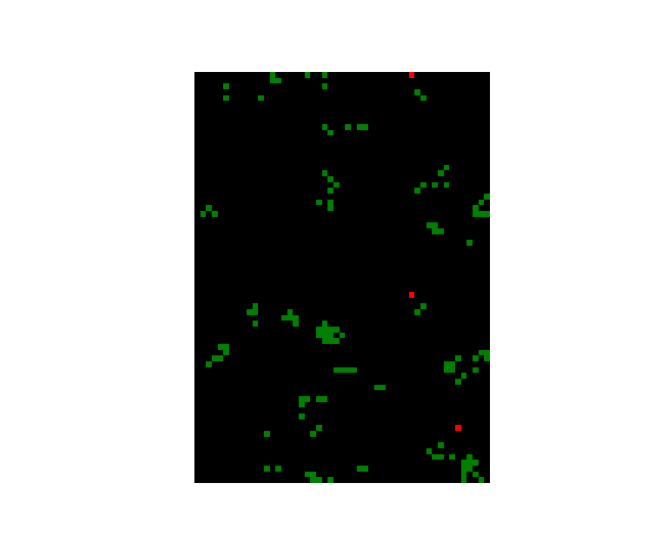

{0: <AgentAction.STEP_BACKWARD: 1>, 1: <AgentAction.STEP_FORWARD: 0>, 2: <AgentAction.STEP_RIGHT: 3>}


KeyboardInterrupt: 

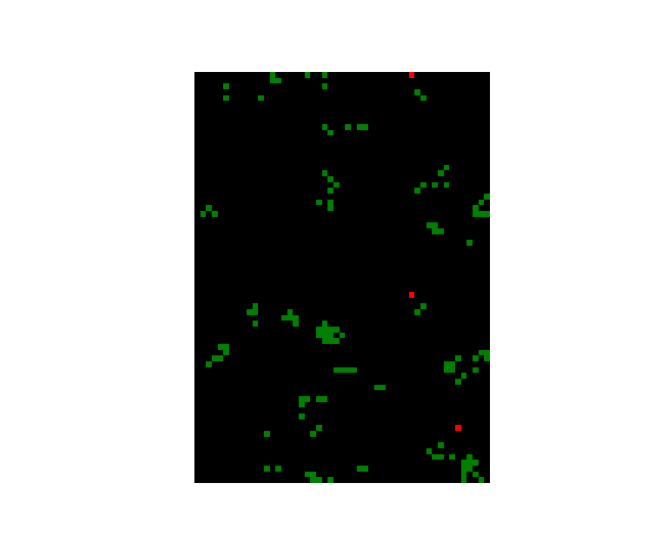

In [211]:
env = gym.make('gym_cpr_grid:CPRGridEnv-v0', n_agents=3, grid_width=51, grid_height=71, initial_resource_probability=0.01)
observations = env.reset()
fig, ax, img = env.plot(env.render('rgb_array'))
for _ in range(env.max_steps):
    display.display(plt.gcf())
    action_dict = {h: env.action_space.sample() for h in range(env.n_agents)}
    print(action_dict)
    observations, rewards, dones, infos = env.step(action_dict)
    print(infos)
    display.clear_output(wait=True)
    img.set_data(env.render(mode='rgb_array'))
env.close()

## Tensorboard

In [ ]:
%tensorboard --logdir "~/ray_results"

## DQN

In [ ]:
ModelCatalog.register_custom_model("fcn", models.FCNetwork)

In [ ]:
reporter = JupyterNotebookReporter(
    overwrite=True, 
    metric_columns={
        "custom_metrics/efficiency_mean": "U",
        "custom_metrics/equality_mean": "E",
        "custom_metrics/sustainability_mean": "S",
        "custom_metrics/peace_mean": "P"
    }
)

In [213]:
max_steps = 1000
dqn_common_config = {
    "env": "gym_cpr_grid:CPRGridEnv-v0", 
    "env_config": {
        "n_agents": 3,
        "grid_width": 5,
        "grid_height": 7,
        "max_steps": max_steps,
    }, 
    "num_workers": 1, 
    "framework": "torch",
    "model": {
        "custom_model": "fcn",
        "fcnet_hiddens": [32, 32],
        "fcnet_activation": "relu",
    },
    "exploration_config": {
        "type": "EpsilonGreedy",
        "initial_epsilon": 1.0,
        "final_epsilon": 0.1,
        "epsilon_timesteps": max_steps,
    },
    "callbacks": metrics.SocialOutcomeMetrics,
    "logger_config": {
        "wandb": {
            "project": "cpr-appropriation",
            "api_key_file": "./wandb_api_key_file",
            "log_config": True,
            'sync_tensorboard': True,
        }
    }
}

### Without tagging

In [166]:
config_dqn_without_tagging = dict(dqn_common_config)
config_dqn_without_tagging["env_config"]["tagging_ability"] = False
experiment_analysis = tune.run(
    DQNTrainer, 
    config=config_dqn_without_tagging,
    progress_reporter=reporter,
    loggers=DEFAULT_LOGGERS + (WandbLogger, )
)

Trial name,status,loc,U,E,S,P
DQN_gym_cpr_grid:CPRGridEnv-v0_ff9d7_00000,RUNNING,192.168.1.110:70670,0.444304,0.965422,252.159,nan


(pid=70670) 2021-08-17 14:17:23,910	ERROR worker.py:421 -- SystemExit was raised from the worker
(pid=70670) Traceback (most recent call last):
(pid=70670)   File "python/ray/_raylet.pyx", line 632, in ray._raylet.task_execution_handler
(pid=70670)   File "python/ray/_raylet.pyx", line 486, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 523, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 530, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 534, in ray._raylet.execute_task
(pid=70670)   File "python/ray/_raylet.pyx", line 484, in ray._raylet.execute_task.function_executor
(pid=70670)   File "/Users/jobs/Github/cpr-appropriation/venv/lib/python3.9/site-packages/ray/_private/function_manager.py", line 563, in actor_method_executor
(pid=70670)     return method(__ray_actor, *args, **kwargs)
(pid=70670)   File "/Users/jobs/Github/cpr-appropriation/venv/lib/python3.9/site-packages/ray/tune/trainable.p

Process _WandbLoggingProcess-11:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/jobs/Github/cpr-appropriation/venv/lib/python3.9/site-packages/ray/tune/integration/wandb.py", line 200, in run
    result = self.queue.get()
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/usr/local/Cellar/python@3.9/3.9.5/Frameworks/Python.frame

KeyboardInterrupt: 

### With tagging

In [ ]:
config_dqn_with_tagging = dict(dqn_common_config)
config_dqn_with_tagging["env_config"]["tagging_ability"] = True
experiment_analysis = tune.run(
    DQNTrainer, 
    config=config_dqn_with_tagging,
    progress_reporter=reporter,
    loggers=DEFAULT_LOGGERS + (WandbLogger, )
)

### With gifting

#### Zero sum

In [ ]:
config_dqn_with_zero_sum_gifting = dict(dqn_common_config)
config_dqn_with_zero_sum_gifting["env_config"]["tagging_ability"] = False
config_dqn_with_zero_sum_gifting["env_config"]["gifting_mechanism"] = 0
experiment_analysis = tune.run(
    DQNTrainer, 
    config=config_dqn_with_zero_sum_gifting,
    progress_reporter=reporter,
    loggers=DEFAULT_LOGGERS + (WandbLogger, )
)

#### Fixed budget

In [ ]:
config_dqn_with_fixed_budget_gifting = dict(dqn_common_config)
config_dqn_with_fixed_budget_gifting["env_config"]["tagging_ability"] = False
config_dqn_with_fixed_budget_gifting["env_config"]["gifting_mechanism"] = 1
experiment_analysis = tune.run(
    DQNTrainer, 
    config=config_dqn_with_fixed_budget_gifting,
    progress_reporter=reporter,
    loggers=DEFAULT_LOGGERS + (WandbLogger, )
)

#### Replenishable budget

In [ ]:
config_dqn_with_replenishable_budget_gifting = dict(dqn_common_config)
config_dqn_with_replenishable_budget_gifting["env_config"]["tagging_ability"] = False
config_dqn_with_replenishable_budget_gifting["env_config"]["gifting_mechanism"] = 2
experiment_analysis = tune.run(
    DQNTrainer, 
    config=config_dqn_with_replenishable_budget_gifting,
    progress_reporter=reporter,
    loggers=DEFAULT_LOGGERS + (WandbLogger, )
)

## Policy gradient methods

In [158]:
env = gym.make('gym_cpr_grid:CPRGridEnv-v0', n_agents=3, grid_width=5, grid_height=7, initial_resource_probability=0.01)
policy_nn = models.MLP(env.observation_space_size(), [32, 32], env.action_space_size())
baseline_nn = models.MLP(env.observation_space_size(), [32, 32], 1)

In [159]:
policy_nn

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=1260, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=9, bias=True)
    (5): ReLU()
  )
  (out): LogSoftmax(dim=None)
)

In [160]:
baseline_nn

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=1260, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): ReLU()
  )
  (out): LogSoftmax(dim=None)
)

## VPG

In [148]:
vpg_policy = policies.VPGPolicy(env, policy_nn, reset_parameters=True, baseline_nn=baseline_nn)
vpg_policy.train(1)

2021-08-23 10:21:47.768 | INFO     | src.policies:train:45 - Epoch 1 / 1
2021-08-23 10:21:47.782 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:47.792 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:47.801 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:47.811 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:50.691 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:50.699 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:50.709 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:50.718 | INFO     | src.policies:execute_episode:150 - Early stopping, all agents done
2021-08-23 10:21:50.727 | INFO     | src.policies:execute_episode:150 - Early stopping, all age

torch.Size([126, 1000, 9]) torch.Size([126, 1000, 9])


## TRPO

In [154]:
trpo_policy = policies.TRPOPolicy(env, policy_nn, baseline_nn, reset_parameters=True, beta=1.0, kl_target=0.01)
trpo_policy.train(1)

2021-08-23 10:25:23.754 | INFO     | src.policies:train:45 - Epoch 1 / 1
2021-08-23 10:25:23.765 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.532 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.540 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.550 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.559 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.569 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.578 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.588 | INFO     | src.policies:execute_episode:149 - Early stopping, all agents done
2021-08-23 10:25:26.597 | INFO     | src.policies:execute_episode:149 - Early stopping, all age

## PPO

In [161]:
ppo_policy = policies.PPOPolicy(env, policy_nn, baseline_nn, reset_parameters=True, c1=1.0, c2=0.0, eps=0.2)
ppo_policy.train(1)

2021-08-23 10:27:20.841 | INFO     | src.policies:train:45 - Epoch 1 / 1


[-2.2404454 -2.2404454 -2.1510057 -2.2404454 -2.1152527 -2.0918565
 -2.2301059 -2.2404454 -2.2404454]
[0.10641111 0.10641111 0.11636706 0.10641111 0.1206028  0.12345771
 0.10751705 0.10641111 0.10641111]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.2395663 -2.2395663 -2.1558986 -2.2395663 -2.1126065 -2.092895
 -2.2309568 -2.2395663 -2.2395663]
[0.10650469 0.10650469 0.11579908 0.10650469 0.12092237 0.12332957
 0.1074256  0.10650469 0.10650469]
[-2.2404454 -2.2404454 -2.1510057 -2.2404454 -2.1152527 -2.0918565
 -2.2301059 -2.2404454 -2.2404454]
[0.10641111 0.10641111 0.11636706 0.10641111 0.1206028  0.12345771
 0.10751705 0.10641111 0.10641111]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.1065

[-2.2402015 -2.2402015 -2.1454556 -2.2402015 -2.1139288 -2.0975552
 -2.2323017 -2.2402015 -2.2402015]
[0.10643706 0.10643706 0.11701471 0.10643706 0.12076258 0.12275618
 0.10728122 0.10643706 0.10643706]
[-2.2392664 -2.2392664 -2.1528263 -2.2392664 -2.1140027 -2.092188
 -2.2350116 -2.2392664 -2.2392664]
[0.10653664 0.10653664 0.11615539 0.10653664 0.12075365 0.12341682
 0.1069909  0.10653664 0.10653664]
[-2.2396293 -2.2396293 -2.1553032 -2.2396293 -2.1229475 -2.0809426
 -2.233514  -2.2396293 -2.2396293]
[0.10649798 0.10649798 0.11586805 0.10649798 0.11967836 0.1248125
 0.10715123 0.10649798 0.10649798]
[-2.2398636 -2.2398636 -2.1461337 -2.2398636 -2.115579  -2.0955884
 -2.2336361 -2.2398636 -2.2398636]
[0.10647302 0.10647302 0.11693539 0.10647302 0.12056348 0.12299784
 0.10713816 0.10647302 0.10647302]
[-2.2392426 -2.2392426 -2.1551838 -2.2392426 -2.1136317 -2.0914183
 -2.2338805 -2.2392426 -2.2392426]
[0.10653917 0.10653917 0.11588189 0.10653917 0.12079847 0.12351184
 0.10711198 0.106

[-2.2398298 -2.2398298 -2.1508617 -2.2398298 -2.1198149 -2.0861897
 -2.234741  -2.2398298 -2.2398298]
[0.10647663 0.10647663 0.11638381 0.10647663 0.12005384 0.12415931
 0.10701984 0.10647663 0.10647663]
[-2.2410944 -2.2410944 -2.1414952 -2.2410944 -2.11102   -2.0960114
 -2.2372606 -2.2410944 -2.2410944]
[0.10634206 0.10634206 0.11747906 0.10634206 0.12111436 0.12294582
 0.10675054 0.10634206 0.10634206]
[-2.238738  -2.238738  -2.1531553 -2.238738  -2.114326  -2.0931885
 -2.2357676 -2.238738  -2.238738 ]
[0.10659293 0.10659293 0.1161172  0.10659293 0.12071463 0.12329338
 0.10691004 0.10659293 0.10659293]
[-2.2398298 -2.2398298 -2.1508617 -2.2398298 -2.1198149 -2.0861897
 -2.234741  -2.2398298 -2.2398298]
[0.10647663 0.10647663 0.11638381 0.10647663 0.12005384 0.12415931
 0.10701984 0.10647663 0.10647663]
[-2.2410944 -2.2410944 -2.1414952 -2.2410944 -2.11102   -2.0960114
 -2.2372606 -2.2410944 -2.2410944]
[0.10634206 0.10634206 0.11747906 0.10634206 0.12111436 0.12294582
 0.10675054 0.1

[-2.2402656 -2.2402656 -2.1499233 -2.2402656 -2.1209064 -2.083126
 -2.2359312 -2.2402656 -2.2402656]
[0.10643023 0.10643023 0.11649308 0.10643023 0.11992288 0.12454028
 0.10689255 0.10643023 0.10643023]
[-2.2401829 -2.2401829 -2.1434646 -2.2401829 -2.1156793 -2.0943723
 -2.236256  -2.2401829 -2.2401829]
[0.10643904 0.10643904 0.11724792 0.10643904 0.12055137 0.12314752
 0.10685785 0.10643904 0.10643904]
[-2.2388046 -2.2388046 -2.1616313 -2.2388046 -2.114725  -2.0819933
 -2.2388046 -2.2388046 -2.2388046]
[0.10658585 0.10658585 0.11513714 0.10658585 0.12066646 0.12468144
 0.10658585 0.10658585 0.10658585]
[-2.2402656 -2.2402656 -2.1499233 -2.2402656 -2.1209064 -2.083126
 -2.2359312 -2.2402656 -2.2402656]
[0.10643023 0.10643023 0.11649308 0.10643023 0.11992288 0.12454028
 0.10689255 0.10643023 0.10643023]
[-2.2401829 -2.2401829 -2.1434646 -2.2401829 -2.1156793 -2.0943723
 -2.236256  -2.2401829 -2.2401829]
[0.10643904 0.10643904 0.11724792 0.10643904 0.12055137 0.12314752
 0.10685785 0.106

[-2.239611  -2.239611  -2.1522307 -2.239611  -2.119984  -2.0835927
 -2.2371724 -2.239611  -2.239611 ]
[0.10649993 0.10649993 0.11622459 0.10649993 0.12003356 0.12448219
 0.10675996 0.10649993 0.10649993]
[-2.2401826 -2.2401826 -2.1440098 -2.2401826 -2.1098642 -2.0961635
 -2.2401826 -2.2401826 -2.2401826]
[0.10643907 0.10643907 0.11718401 0.10643907 0.12125443 0.12292713
 0.10643907 0.10643907 0.10643907]
[-2.2385135 -2.2385135 -2.15912   -2.2385135 -2.1165595 -2.0870476
 -2.2350123 -2.2385135 -2.2385135]
[0.10661688 0.10661688 0.11542664 0.10661688 0.12044531 0.12405284
 0.10699082 0.10661688 0.10661688]
[-2.2394316 -2.2394316 -2.151904  -2.2394316 -2.1192513 -2.0834363
 -2.2394316 -2.2394316 -2.2394316]
[0.10651904 0.10651904 0.11626257 0.10651904 0.12012154 0.12450166
 0.10651904 0.10651904 0.10651904]
[-2.2401543 -2.2401543 -2.1417503 -2.2401543 -2.1098895 -2.0984442
 -2.2401543 -2.2401543 -2.2401543]
[0.10644208 0.10644208 0.11744908 0.10644208 0.12125135 0.12264709
 0.10644208 0.1

[-2.2400308 -2.2400308 -2.146251  -2.2400308 -2.1141264 -2.0965428
 -2.2332182 -2.2400308 -2.2400308]
[0.10645524 0.10645524 0.11692169 0.10645524 0.12073872 0.12288052
 0.10718294 0.10645524 0.10645524]
[-2.2398322 -2.2398322 -2.143679  -2.2398322 -2.1145782 -2.0978715
 -2.2349849 -2.2398322 -2.2398322]
[0.10647637 0.10647637 0.11722279 0.10647637 0.12068418 0.12271734
 0.10699376 0.10647637 0.10647637]
[-2.2422678 -2.2422678 -2.1505127 -2.2422678 -2.1078172 -2.0862515
 -2.2364774 -2.2422678 -2.2422678]
[0.10621734 0.10621734 0.11642445 0.10621734 0.12150291 0.12415165
 0.10683418 0.10621734 0.10621734]
[-2.2400308 -2.2400308 -2.146251  -2.2400308 -2.1141264 -2.0965428
 -2.2332182 -2.2400308 -2.2400308]
[0.10645524 0.10645524 0.11692169 0.10645524 0.12073872 0.12288052
 0.10718294 0.10645524 0.10645524]
[-2.2398322 -2.2398322 -2.143679  -2.2398322 -2.1145782 -2.0978715
 -2.2349849 -2.2398322 -2.2398322]
[0.10647637 0.10647637 0.11722279 0.10647637 0.12068418 0.12271734
 0.10699376 0.1

[-2.23919   -2.23919   -2.1461508 -2.23919   -2.1207995 -2.0888216
 -2.238915  -2.23919   -2.23919  ]
[0.10654476 0.10654476 0.11693339 0.10654476 0.1199357  0.12383297
 0.10657407 0.10654476 0.10654476]
[-2.239082  -2.239082  -2.149245  -2.239082  -2.1172101 -2.0954583
 -2.2324457 -2.239082  -2.239082 ]
[0.10655627 0.10655627 0.11657213 0.10655627 0.12036696 0.12301385
 0.10726578 0.10655627 0.10655627]
[-2.2405448 -2.2405448 -2.1379006 -2.2405448 -2.1219745 -2.1009917
 -2.2259445 -2.2405448 -2.2405448]
[0.10640052 0.10640052 0.11790211 0.10640052 0.11979487 0.12233504
 0.10796539 0.10640052 0.10640052]
[-2.23919   -2.23919   -2.1461508 -2.23919   -2.1207995 -2.0888216
 -2.238915  -2.23919   -2.23919  ]
[0.10654476 0.10654476 0.11693339 0.10654476 0.1199357  0.12383297
 0.10657407 0.10654476 0.10654476]
[-2.239082  -2.239082  -2.149245  -2.239082  -2.1172101 -2.0954583
 -2.2324457 -2.239082  -2.239082 ]
[0.10655627 0.10655627 0.11657213 0.10655627 0.12036696 0.12301385
 0.10726578 0.1

[-2.2400448 -2.2400448 -2.1529856 -2.2400448 -2.1164718 -2.0871713
 -2.2339835 -2.2400448 -2.2400448]
[0.10645373 0.10645373 0.11613691 0.10645373 0.12045588 0.1240375
 0.10710093 0.10645373 0.10645373]
[-2.2390845 -2.2390845 -2.1494093 -2.2390845 -2.121284  -2.0923557
 -2.231259  -2.2390845 -2.2390845]
[0.10655602 0.10655602 0.11655299 0.10655602 0.11987761 0.12339611
 0.10739313 0.10655602 0.10655602]
[-2.240158  -2.240158  -2.1580746 -2.240158  -2.1170454 -2.0833373
 -2.2317224 -2.240158  -2.240158 ]
[0.10644167 0.10644167 0.11554737 0.10644167 0.12038679 0.12451398
 0.10734339 0.10644167 0.10644167]
[-2.2400448 -2.2400448 -2.1529856 -2.2400448 -2.1164718 -2.0871713
 -2.2339835 -2.2400448 -2.2400448]
[0.10645373 0.10645373 0.11613691 0.10645373 0.12045588 0.1240375
 0.10710093 0.10645373 0.10645373]
[-2.2390845 -2.2390845 -2.1494093 -2.2390845 -2.121284  -2.0923557
 -2.231259  -2.2390845 -2.2390845]
[0.10655602 0.10655602 0.11655299 0.10655602 0.11987761 0.12339611
 0.10739313 0.106

[-2.2403517 -2.2403517 -2.1424096 -2.2403517 -2.113632  -2.096549
 -2.2363784 -2.2403517 -2.2403517]
[0.10642108 0.10642108 0.11737169 0.10642108 0.12079843 0.12287975
 0.10684475 0.10642108 0.10642108]
[-2.2389128 -2.2389128 -2.1535192 -2.2389128 -2.1159885 -2.0931025
 -2.232729  -2.2389128 -2.2389128]
[0.1065743  0.1065743  0.11607496 0.1065743  0.1205141  0.12330399
 0.10723539 0.1065743  0.1065743 ]
[-2.23945   -2.23945   -2.1583607 -2.23945   -2.1145892 -2.0873928
 -2.2329905 -2.23945   -2.23945  ]
[0.10651708 0.10651708 0.11551432 0.10651708 0.12068285 0.12401003
 0.10720734 0.10651708 0.10651708]
[-2.2403517 -2.2403517 -2.1424096 -2.2403517 -2.113632  -2.096549
 -2.2363784 -2.2403517 -2.2403517]
[0.10642108 0.10642108 0.11737169 0.10642108 0.12079843 0.12287975
 0.10684475 0.10642108 0.10642108]
[-2.2391148 -2.2391148 -2.1525815 -2.2391148 -2.1158807 -2.091903
 -2.2342432 -2.2391148 -2.2391148]
[0.10655279 0.10655279 0.11618384 0.10655279 0.12052708 0.12345199
 0.10707314 0.1065

[-2.2402124 -2.2402124 -2.1493132 -2.2402124 -2.1158607 -2.091475
 -2.232854  -2.2402124 -2.2402124]
[0.10643589 0.10643589 0.11656418 0.10643589 0.12052951 0.12350484
 0.107222   0.10643589 0.10643589]
[-2.2396982 -2.2396982 -2.153364  -2.2396982 -2.111918  -2.0878158
 -2.2396982 -2.2396982 -2.2396982]
[0.10649064 0.10649064 0.11609297 0.10649064 0.12100566 0.1239576
 0.10649064 0.10649064 0.10649064]
[-2.2398875 -2.2398875 -2.1469443 -2.2398875 -2.1125224 -2.0983586
 -2.2329032 -2.2398875 -2.2398875]
[0.10647049 0.10647049 0.11684065 0.10647049 0.12093253 0.12265759
 0.10721671 0.10647049 0.10647049]
[-2.2402124 -2.2402124 -2.1493132 -2.2402124 -2.1158607 -2.091475
 -2.232854  -2.2402124 -2.2402124]
[0.10643589 0.10643589 0.11656418 0.10643589 0.12052951 0.12350484
 0.107222   0.10643589 0.10643589]
[-2.2396019 -2.2396019 -2.157274  -2.2396019 -2.1104553 -2.0879605
 -2.2374241 -2.2396019 -2.2396019]
[0.10650089 0.10650089 0.11563993 0.10650089 0.12118278 0.12393966
 0.10673308 0.1065

[-2.2391531 -2.2391531 -2.1525187 -2.2391531 -2.1209874 -2.089692
 -2.2309437 -2.2391531 -2.2391531]
[0.1065487  0.1065487  0.11619113 0.1065487  0.11991317 0.12372522
 0.10742701 0.1065487  0.1065487 ]
[-2.2391307 -2.2391307 -2.1523902 -2.2391307 -2.1182206 -2.0906427
 -2.2331944 -2.2391307 -2.2391307]
[0.10655108 0.10655108 0.11620606 0.10655108 0.1202454  0.12360767
 0.1071855  0.10655108 0.10655108]
[-2.2397876 -2.2397876 -2.1457372 -2.2397876 -2.110208  -2.1014693
 -2.2337732 -2.2397876 -2.2397876]
[0.10648112 0.10648112 0.11698177 0.10648112 0.12121274 0.12227664
 0.10712346 0.10648112 0.10648112]
[-2.2407062 -2.2407062 -2.1464584 -2.2407062 -2.1250606 -2.0880694
 -2.2271621 -2.2407062 -2.2407062]
[0.10638335 0.10638335 0.11689743 0.10638335 0.11942573 0.12392616
 0.10783402 0.10638335 0.10638335]
[-2.2385664 -2.2385664 -2.1557963 -2.2385664 -2.122344  -2.0853772
 -2.2337866 -2.2385664 -2.2385664]
[0.10661123 0.10661123 0.11581094 0.10661123 0.1197506  0.12426024
 0.10712203 0.10

[-2.2378669 -2.2378669 -2.1579406 -2.2378669 -2.1195753 -2.0899205
 -2.2327938 -2.2378669 -2.2378669]
[0.10668584 0.10668584 0.11556286 0.10668584 0.12008262 0.12369697
 0.10722844 0.10668584 0.10668584]
[-2.2400463 -2.2400463 -2.152052  -2.2400463 -2.1163201 -2.088122
 -2.2340598 -2.2400463 -2.2400463]
[0.10645358 0.10645358 0.11624538 0.10645358 0.12047414 0.12391965
 0.10709278 0.10645358 0.10645358]
[-2.2393188 -2.2393188 -2.150628  -2.2393188 -2.1216273 -2.0931778
 -2.2274528 -2.2393188 -2.2393188]
[0.10653105 0.10653105 0.11641102 0.10653105 0.11983646 0.1232947
 0.10780268 0.10653105 0.10653105]
[-2.2391372 -2.2391372 -2.1436212 -2.2391372 -2.115747  -2.0992541
 -2.2356048 -2.2391372 -2.2391372]
[0.1065504  0.1065504  0.11722957 0.1065504  0.12054322 0.1225478
 0.10692744 0.1065504  0.1065504 ]
[-2.2400463 -2.2400463 -2.152052  -2.2400463 -2.1163201 -2.088122
 -2.2340598 -2.2400463 -2.2400463]
[0.10645358 0.10645358 0.11624538 0.10645358 0.12047414 0.12391965
 0.10709278 0.10645

[-2.2390196 -2.2390196 -2.1519566 -2.2390196 -2.110881  -2.0936644
 -2.2390196 -2.2390196 -2.2390196]
[0.10656292 0.10656292 0.11625647 0.10656292 0.12113119 0.12323473
 0.10656292 0.10656292 0.10656292]
[-2.2393603 -2.2393603 -2.1584306 -2.2393603 -2.1171525 -2.0846872
 -2.2336125 -2.2393603 -2.2393603]
[0.10652662 0.10652662 0.11550625 0.10652662 0.12037391 0.12434601
 0.10714068 0.10652662 0.10652662]
[-2.2396722 -2.2396722 -2.154033  -2.2396722 -2.1112454 -2.087982
 -2.2396722 -2.2396722 -2.2396722]
[0.10649342 0.10649342 0.11601532 0.10649342 0.12108707 0.12393699
 0.10649342 0.10649342 0.10649342]
[-2.2403548 -2.2403548 -2.1565113 -2.2403548 -2.110472  -2.0870273
 -2.235563  -2.2403548 -2.2403548]
[0.10642075 0.10642075 0.11572816 0.10642075 0.12118076 0.12405537
 0.10693191 0.10642075 0.10642075]
[-2.2393603 -2.2393603 -2.1584306 -2.2393603 -2.1171525 -2.0846872
 -2.2336125 -2.2393603 -2.2393603]
[0.10652662 0.10652662 0.11550625 0.10652662 0.12037391 0.12434601
 0.10714068 0.10

[-2.2399476 -2.2399476 -2.1566806 -2.2399476 -2.1183972 -2.0846639
 -2.2312157 -2.2399476 -2.2399476]
[0.10646409 0.10646409 0.11570857 0.10646409 0.12022417 0.1243489
 0.10739778 0.10646409 0.10646409]
[-2.2393086 -2.2393086 -2.1387389 -2.2393086 -2.1273646 -2.1030087
 -2.222881  -2.2393086 -2.2393086]
[0.10653213 0.10653213 0.11780331 0.10653213 0.11915088 0.12208853
 0.10829665 0.10653213 0.10653213]
[-2.2397451 -2.2397451 -2.1515162 -2.2397451 -2.11203   -2.0891984
 -2.2397451 -2.2397451 -2.2397451]
[0.10648564 0.10648564 0.11630768 0.10648564 0.1209921  0.12378633
 0.10648564 0.10648564 0.10648564]
[-2.2408333 -2.2408333 -2.1521757 -2.2408333 -2.1214976 -2.0806577
 -2.2328734 -2.2408333 -2.2408333]
[0.10636983 0.10636983 0.11623099 0.10636983 0.11985199 0.12484808
 0.1072199  0.10636983 0.10636983]
[-2.2389085 -2.2389085 -2.1359055 -2.2389085 -2.128451  -2.1029534
 -2.2268107 -2.2389085 -2.2389085]
[0.10657476 0.10657476 0.11813757 0.10657476 0.1190215  0.12209529
 0.10787192 0.10

[-2.24004   -2.24004   -2.1488194 -2.24004   -2.1109424 -2.102775
 -2.2268636 -2.24004   -2.24004  ]
[0.10645424 0.10645424 0.11662176 0.10645424 0.12112378 0.12211707
 0.10786621 0.10645424 0.10645424]
[-2.238259  -2.238259  -2.1541996 -2.238259  -2.1220288 -2.0846412
 -2.238259  -2.238259  -2.238259 ]
[0.106644   0.106644   0.115996   0.106644   0.11978836 0.12435173
 0.106644   0.106644   0.106644  ]
[-2.2400448 -2.2400448 -2.1529856 -2.2400448 -2.1164718 -2.0871713
 -2.2339835 -2.2400448 -2.2400448]
[0.10645373 0.10645373 0.11613691 0.10645373 0.12045588 0.1240375
 0.10710093 0.10645373 0.10645373]
[-2.239188  -2.239188  -2.153435  -2.239188  -2.1188936 -2.0878918
 -2.2341998 -2.239188  -2.239188 ]
[0.10654499 0.10654499 0.11608472 0.10654499 0.12016451 0.12394816
 0.10707778 0.10654499 0.10654499]
[-2.2389205 -2.2389205 -2.1515236 -2.2389205 -2.1210234 -2.0858212
 -2.2376227 -2.2389205 -2.2389205]
[0.10657349 0.10657349 0.11630683 0.10657349 0.11990885 0.12420509
 0.10671188 0.106

[-2.2402594 -2.2402594 -2.1505816 -2.2402594 -2.1129825 -2.0960205
 -2.2292643 -2.2402594 -2.2402594]
[0.10643089 0.10643089 0.11641643 0.10643089 0.12087691 0.12294471
 0.10760757 0.10643089 0.10643089]
[-2.2401493 -2.2401493 -2.1433244 -2.2401493 -2.1187303 -2.094556
 -2.2329335 -2.2401493 -2.2401493]
[0.10644261 0.10644261 0.11726436 0.10644261 0.12018413 0.12312489
 0.10721345 0.10644261 0.10644261]
[-2.24029   -2.24029   -2.1526499 -2.24029   -2.1108272 -2.0960867
 -2.229228  -2.24029   -2.24029  ]
[0.10642764 0.10642764 0.1161759  0.10642764 0.12113772 0.12293658
 0.10761147 0.10642764 0.10642764]
[-2.2419634 -2.2419634 -2.1419623 -2.2419634 -2.1105006 -2.097853
 -2.2309124 -2.2419634 -2.2419634]
[0.1062497  0.1062497  0.1174242  0.1062497  0.12117729 0.12271963
 0.10743036 0.1062497  0.1062497 ]
[-2.2408292 -2.2408292 -2.1508965 -2.2408292 -2.1196575 -2.0882285
 -2.2275722 -2.2408292 -2.2408292]
[0.10637026 0.10637026 0.11637977 0.10637026 0.12007275 0.12390644
 0.10778981 0.106

[-2.2400265 -2.2400265 -2.1551347 -2.2400265 -2.1192613 -2.0813577
 -2.2353668 -2.2400265 -2.2400265]
[0.10645569 0.10645569 0.11588759 0.10645569 0.12012033 0.1247607
 0.10695289 0.10645569 0.10645569]
[-2.2386546 -2.2386546 -2.147784  -2.2386546 -2.124374  -2.0869045
 -2.2380161 -2.2386546 -2.2386546]
[0.10660183 0.10660183 0.11674257 0.10660183 0.11950776 0.1240706
 0.10666991 0.10660183 0.10660183]
[-2.2389467 -2.2389467 -2.1573064 -2.2389467 -2.1165955 -2.0839796
 -2.23834   -2.2389467 -2.2389467]
[0.10657071 0.10657071 0.11563617 0.10657071 0.12044098 0.12443403
 0.10663538 0.10657071 0.10657071]
[-2.2396102 -2.2396102 -2.1563005 -2.2396102 -2.121651  -2.0792277
 -2.2359836 -2.2396102 -2.2396102]
[0.10650001 0.10650001 0.11575256 0.10650001 0.11983363 0.12502673
 0.10688695 0.10650001 0.10650001]
[-2.2386937 -2.2386937 -2.1495378 -2.2386937 -2.124777  -2.0851247
 -2.2375245 -2.2386937 -2.2386937]
[0.10659766 0.10659766 0.11653801 0.10659766 0.11945959 0.12429161
 0.10672236 0.106

[-2.2400565 -2.2400565 -2.1481848 -2.2400565 -2.1167672 -2.093216
 -2.2318332 -2.2400565 -2.2400565]
[0.10645249 0.10645249 0.11669578 0.10645249 0.12042029 0.12328999
 0.10733148 0.10645249 0.10645249]
[-2.2391422 -2.2391422 -2.147399  -2.2391422 -2.1230595 -2.0890548
 -2.2349834 -2.2391422 -2.2391422]
[0.10654986 0.10654986 0.11678754 0.10654986 0.11966495 0.1238041
 0.1069939  0.10654986 0.10654986]
[-2.2392485 -2.2392485 -2.1577222 -2.2392485 -2.1161268 -2.090471
 -2.2294009 -2.2392485 -2.2392485]
[0.10653854 0.10653854 0.1155881  0.10653854 0.12049744 0.12362888
 0.10759287 0.10653854 0.10653854]
[-2.2396324 -2.2396324 -2.1470764 -2.2396324 -2.120697  -2.091639
 -2.2325573 -2.2396324 -2.2396324]
[0.10649765 0.10649765 0.11682522 0.10649765 0.11994799 0.12348457
 0.1072538  0.10649765 0.10649765]
[-2.2396302 -2.2396302 -2.1479907 -2.2396302 -2.1225607 -2.0873702
 -2.2344165 -2.2396302 -2.2396302]
[0.10649787 0.10649787 0.11671845 0.10649787 0.11972465 0.12401284
 0.10705458 0.10649

[-2.238561  -2.238561  -2.1530073 -2.238561  -2.1132524 -2.0955217
 -2.235335  -2.238561  -2.238561 ]
[0.10661182 0.10661182 0.11613438 0.10661182 0.12084429 0.12300606
 0.10695628 0.10661182 0.10661182]
[-2.239029  -2.239029  -2.1532116 -2.239029  -2.1163144 -2.0925574
 -2.232744  -2.239029  -2.239029 ]
[0.10656194 0.10656194 0.11611066 0.10656194 0.12047483 0.12337122
 0.10723378 0.10656194 0.10656194]
[-2.2402685 -2.2402685 -2.153769  -2.2402685 -2.1121535 -2.091288
 -2.232132  -2.2402685 -2.2402685]
[0.10642993 0.10642993 0.11604595 0.10642993 0.12097716 0.12352791
 0.10729943 0.10642993 0.10642993]
[-2.2393062 -2.2393062 -2.1519883 -2.2393062 -2.107567  -2.1006978
 -2.233236  -2.2393062 -2.2393062]
[0.10653239 0.10653239 0.11625279 0.10653239 0.1215333  0.12237102
 0.10718103 0.10653239 0.10653239]
[-2.2386546 -2.2386546 -2.1609967 -2.2386546 -2.1210852 -2.0840437
 -2.2307007 -2.2386546 -2.2386546]
[0.10660183 0.10660183 0.11521024 0.10660183 0.11990144 0.12442604
 0.10745311 0.10

[-2.2381868 -2.2381868 -2.1518946 -2.2381868 -2.1193914 -2.094576
 -2.232586  -2.2381868 -2.2381868]
[0.1066517  0.1066517  0.11626367 0.1066517  0.1201047  0.12312245
 0.10725073 0.1066517  0.1066517 ]
[-2.2382312 -2.2382312 -2.1549091 -2.2382312 -2.1163611 -2.0907416
 -2.236922  -2.2382312 -2.2382312]
[0.10664698 0.10664698 0.11591373 0.10664698 0.12046921 0.12359545
 0.10678668 0.10664698 0.10664698]
[-2.2398145 -2.2398145 -2.1479075 -2.2398145 -2.1125689 -2.09581
 -2.2350857 -2.2398145 -2.2398145]
[0.10647826 0.10647826 0.11672816 0.10647826 0.12092692 0.1229706
 0.10698296 0.10647826 0.10647826]
[-2.2383063 -2.2383063 -2.1545405 -2.2383063 -2.1217222 -2.0872703
 -2.234942  -2.2383063 -2.2383063]
[0.10663897 0.10663897 0.11595646 0.10663897 0.11982508 0.12402523
 0.10699834 0.10663897 0.10663897]
[-2.2403312 -2.2403312 -2.15838   -2.2403312 -2.112473  -2.084959
 -2.2337976 -2.2403312 -2.2403312]
[0.10642325 0.10642325 0.11551209 0.10642325 0.12093852 0.12431221
 0.10712086 0.106423

[-2.2400208 -2.2400208 -2.147825  -2.2400208 -2.1219563 -2.092766
 -2.2271216 -2.2400208 -2.2400208]
[0.10645629 0.10645629 0.11673778 0.10645629 0.11979704 0.12334549
 0.10783838 0.10645629 0.10645629]
[-2.2392833 -2.2392833 -2.1521754 -2.2392833 -2.117697  -2.0854456
 -2.2392833 -2.2392833 -2.2392833]
[0.10653483 0.10653483 0.11623103 0.10653483 0.12030838 0.12425172
 0.10653483 0.10653483 0.10653483]
[-2.240671  -2.240671  -2.1518817 -2.240671  -2.1137197 -2.0881743
 -2.2340074 -2.240671  -2.240671 ]
[0.1063871  0.1063871  0.11626518 0.1063871  0.12078783 0.12391315
 0.10709839 0.1063871  0.1063871 ]
[-2.2400208 -2.2400208 -2.147825  -2.2400208 -2.1219563 -2.092766
 -2.2271216 -2.2400208 -2.2400208]
[0.10645629 0.10645629 0.11673778 0.10645629 0.11979704 0.12334549
 0.10783838 0.10645629 0.10645629]
[-2.2396557 -2.2396557 -2.1533446 -2.2396557 -2.1092577 -2.0925543
 -2.2374597 -2.2396557 -2.2396557]
[0.10649516 0.10649516 0.11609521 0.10649516 0.121328   0.12337161
 0.10672929 0.106

[-2.2387538 -2.2387538 -2.1486077 -2.2387538 -2.1190894 -2.09788
 -2.2298949 -2.2387538 -2.2387538]
[0.10659125 0.10659125 0.11664645 0.10659125 0.12014098 0.12271632
 0.10753974 0.10659125 0.10659125]
[-2.2395523 -2.2395523 -2.1522954 -2.2395523 -2.118903  -2.0878718
 -2.233638  -2.2395523 -2.2395523]
[0.10650618 0.10650618 0.1162171  0.10650618 0.12016338 0.12395065
 0.10713794 0.10650618 0.10650618]
[-2.2399635 -2.2399635 -2.148872  -2.2399635 -2.1176999 -2.0888155
 -2.2355752 -2.2399635 -2.2399635]
[0.10646238 0.10646238 0.11661565 0.10646238 0.12030803 0.12383374
 0.1069306  0.10646238 0.10646238]
[-2.2387538 -2.2387538 -2.1486077 -2.2387538 -2.1190894 -2.09788
 -2.2298949 -2.2387538 -2.2387538]
[0.10659125 0.10659125 0.11664645 0.10659125 0.12014098 0.12271632
 0.10753974 0.10659125 0.10659125]
[-2.2395523 -2.2395523 -2.1522954 -2.2395523 -2.118903  -2.0878718
 -2.233638  -2.2395523 -2.2395523]
[0.10650618 0.10650618 0.1162171  0.10650618 0.12016338 0.12395065
 0.10713794 0.10650

[-2.2391632 -2.2391632 -2.1563814 -2.2391632 -2.1144252 -2.0901268
 -2.2335777 -2.2391632 -2.2391632]
[0.10654763 0.10654763 0.11574319 0.10654763 0.12070266 0.12367146
 0.10714441 0.10654763 0.10654763]
[-2.2389889 -2.2389889 -2.1537478 -2.2389889 -2.1170225 -2.0886605
 -2.236065  -2.2389889 -2.2389889]
[0.10656621 0.10656621 0.11604842 0.10656621 0.12038954 0.12385293
 0.10687825 0.10656621 0.10656621]
[-2.2395768 -2.2395768 -2.1525326 -2.2395768 -2.1168425 -2.0907314
 -2.2322698 -2.2395768 -2.2395768]
[0.10650356 0.10650356 0.11618953 0.10650356 0.12041123 0.12359671
 0.10728464 0.10650356 0.10650356]
[-2.239101  -2.239101  -2.143838  -2.239101  -2.117666  -2.09955
 -2.2330499 -2.239101  -2.239101 ]
[0.10655426 0.10655426 0.11720416 0.10655426 0.1203121  0.12251154
 0.10720098 0.10655426 0.10655426]
[-2.2383747 -2.2383747 -2.1547992 -2.2383747 -2.1193492 -2.0885384
 -2.2355118 -2.2383747 -2.2383747]
[0.10663167 0.10663167 0.11592647 0.10663167 0.12010976 0.12386804
 0.10693739 0.106

2021-08-23 10:27:25.527 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done


[-2.2389295 -2.2389295 -2.1494913 -2.2389295 -2.1124544 -2.0994706
 -2.2336955 -2.2389295 -2.2389295]
[0.10657253 0.10657253 0.11654343 0.10657253 0.12094077 0.12252127
 0.10713179 0.10657253 0.10657253]
[-2.2392166 -2.2392166 -2.1393738 -2.2392166 -2.1153412 -2.1010885
 -2.238236  -2.2392166 -2.2392166]
[0.10654194 0.10654194 0.11772855 0.10654194 0.12059215 0.12232321
 0.10664646 0.10654194 0.10654194]
[-2.2401993 -2.2401993 -2.1486256 -2.2401993 -2.1166434 -2.0887775
 -2.2359037 -2.2401993 -2.2401993]
[0.10643728 0.10643728 0.11664435 0.10643728 0.12043521 0.12383842
 0.10689548 0.10643728 0.10643728]
[-2.2389295 -2.2389295 -2.1494913 -2.2389295 -2.1124544 -2.0994706
 -2.2336955 -2.2389295 -2.2389295]
[0.10657253 0.10657253 0.11654343 0.10657253 0.12094077 0.12252127
 0.10713179 0.10657253 0.10657253]
[-2.2403183 -2.2403183 -2.1461315 -2.2403183 -2.109077  -2.0988376
 -2.2349958 -2.2403183 -2.2403183]
[0.10642463 0.10642463 0.11693564 0.10642463 0.12134992 0.12259885
 0.10699258 0.1

2021-08-23 10:27:25.879 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:25.890 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done


[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.2390401 -2.2390401 -2.1565964 -2.2390401 -2.1174734 -2.0885143
 -2.2323902 -2.2390401 -2.2390401]
[0.10656074 0.10656074 0.11571831 0.10656074 0.12033528 0.12387104
 0.10727172 0.10656074 0.10656074]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.2392743 -2.2392743 -2.1566634 -2.2392743 -2.118418  -2.0889106
 -2.2296424 -2.2392743 -2.2392743]
[0.10653579 0.10653579 0.11571056 0.10653579 0.12022167 0.12382196
 0.10756689 0.1065

2021-08-23 10:27:25.901 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:25.914 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:25.925 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:25.935 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:25.947 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done


[-2.2384326 -2.2384326 -2.158976  -2.2384326 -2.1195652 -2.0852556
 -2.2342718 -2.2384326 -2.2384326]
[0.1066255  0.1066255  0.11544327 0.1066255  0.12008382 0.12427535
 0.10707007 0.1066255  0.1066255 ]
[-2.240747  -2.240747  -2.1507623 -2.240747  -2.1080792 -2.0965912
 -2.2315307 -2.240747  -2.240747 ]
[0.106379   0.106379   0.1163954  0.106379   0.12147106 0.12287457
 0.10736396 0.106379   0.106379  ]
[-2.239859  -2.239859  -2.1505127 -2.239859  -2.1183004 -2.0895379
 -2.2327993 -2.239859  -2.239859 ]
[0.10647351 0.10647351 0.11642445 0.10647351 0.1202358  0.12374432
 0.10722785 0.10647351 0.10647351]
[-2.241108  -2.241108  -2.1429    -2.241108  -2.1124005 -2.0985973
 -2.2311273 -2.241108  -2.241108 ]
[0.10634062 0.10634062 0.11731414 0.10634062 0.12094728 0.12262832
 0.10740728 0.10634062 0.10634062]
[-2.24008   -2.24008   -2.1484046 -2.24008   -2.1146128 -2.0954673
 -2.2313125 -2.24008   -2.24008  ]
[0.10644997 0.10644997 0.11667015 0.10644997 0.12068001 0.12301274
 0.10738739 0.1

[-2.2403078 -2.2403078 -2.153781  -2.2403078 -2.115624  -2.0871942
 -2.2327428 -2.2403078 -2.2403078]
[0.10642574 0.10642574 0.11604457 0.10642574 0.12055804 0.12403467
 0.1072339  0.10642574 0.10642574]
[-2.240775  -2.240775  -2.1482656 -2.240775  -2.109708  -2.0949562
 -2.2341378 -2.240775  -2.240775 ]
[0.10637601 0.10637601 0.11668635 0.10637601 0.12127336 0.12307563
 0.10708442 0.10637601 0.10637601]
[-2.238258  -2.238258  -2.1561615 -2.238258  -2.1192565 -2.093821
 -2.2286427 -2.238258  -2.238258 ]
[0.10664413 0.10664413 0.11576863 0.10664413 0.12012091 0.12321542
 0.10767447 0.10664413 0.10664413]
[-2.2387958 -2.2387958 -2.1576009 -2.2387958 -2.1140711 -2.086411
 -2.2387958 -2.2387958 -2.2387958]
[0.10658678 0.10658678 0.11560214 0.10658678 0.12074541 0.12413184
 0.10658678 0.10658678 0.10658678]
[-2.2411134 -2.2411134 -2.1557093 -2.2411134 -2.1041675 -2.0896733
 -2.2367601 -2.2411134 -2.2411134]
[0.10634004 0.10634004 0.11582101 0.10634004 0.12194716 0.12372756
 0.10680398 0.106

[-2.2403314 -2.2403314 -2.152711  -2.2403314 -2.1144776 -2.0864086
 -2.235987  -2.2403314 -2.2403314]
[0.10642324 0.10642324 0.11616881 0.10642324 0.12069631 0.12413215
 0.10688659 0.10642324 0.10642324]
[-2.2402294 -2.2402294 -2.1480453 -2.2402294 -2.1200845 -2.0903547
 -2.230704  -2.2402294 -2.2402294]
[0.10643409 0.10643409 0.11671208 0.10643409 0.12002148 0.12364326
 0.10745274 0.10643409 0.10643409]
[-2.2397325 -2.2397325 -2.143622  -2.2397325 -2.1215467 -2.0895617
 -2.2372818 -2.2397325 -2.2397325]
[0.10648698 0.10648698 0.11722948 0.10648698 0.11984611 0.12374137
 0.10674828 0.10648698 0.10648698]
[-2.2403314 -2.2403314 -2.152711  -2.2403314 -2.1144776 -2.0864086
 -2.235987  -2.2403314 -2.2403314]
[0.10642324 0.10642324 0.11616881 0.10642324 0.12069631 0.12413215
 0.10688659 0.10642324 0.10642324]
[-2.2402294 -2.2402294 -2.1480453 -2.2402294 -2.1200845 -2.0903547
 -2.230704  -2.2402294 -2.2402294]
[0.10643409 0.10643409 0.11671208 0.10643409 0.12002148 0.12364326
 0.10745274 0.1

[-2.239764  -2.239764  -2.1538153 -2.239764  -2.1180122 -2.0869205
 -2.233039  -2.239764  -2.239764 ]
[0.10648363 0.10648363 0.11604059 0.10648363 0.12027047 0.12406862
 0.10720215 0.10648363 0.10648363]
[-2.239852  -2.239852  -2.1484685 -2.239852  -2.116388  -2.0952964
 -2.2305794 -2.239852  -2.239852 ]
[0.10647427 0.10647427 0.11666269 0.10647427 0.12046595 0.12303377
 0.10746615 0.10647427 0.10647427]
[-2.2397761 -2.2397761 -2.1561122 -2.2397761 -2.1143172 -2.0874047
 -2.2340884 -2.2397761 -2.2397761]
[0.10648233 0.10648233 0.11577436 0.10648233 0.12071569 0.12400856
 0.10708971 0.10648233 0.10648233]
[-2.239797  -2.239797  -2.1502383 -2.239797  -2.1169136 -2.091327
 -2.2328968 -2.239797  -2.239797 ]
[0.10648011 0.10648011 0.11645641 0.10648011 0.12040267 0.12352312
 0.10721739 0.10648011 0.10648011]
[-2.239536  -2.239536  -2.150563  -2.239536  -2.1212456 -2.08942
 -2.231187  -2.239536  -2.239536 ]
[0.10650791 0.10650791 0.11641859 0.10650791 0.11988221 0.12375888
 0.10740085 0.1065

[-2.2391338 -2.2391338 -2.1541471 -2.2391338 -2.1176865 -2.0906475
 -2.231872  -2.2391338 -2.2391338]
[0.10655075 0.10655075 0.11600208 0.10655075 0.12030964 0.12360708
 0.10732732 0.10655075 0.10655075]
[-2.23982   -2.23982   -2.1506147 -2.23982   -2.113215  -2.0936587
 -2.2338536 -2.23982   -2.23982  ]
[0.10647767 0.10647767 0.11641257 0.10647767 0.12084882 0.12323543
 0.10711485 0.10647767 0.10647767]
[-2.2398431 -2.2398431 -2.1518393 -2.2398431 -2.1135075 -2.0876908
 -2.238978  -2.2398431 -2.2398431]
[0.1064752  0.1064752  0.11627011 0.1064752  0.12081346 0.12397309
 0.10656737 0.1064752  0.1064752 ]
[-2.2391338 -2.2391338 -2.1541471 -2.2391338 -2.1176865 -2.0906475
 -2.231872  -2.2391338 -2.2391338]
[0.10655075 0.10655075 0.11600208 0.10655075 0.12030964 0.12360708
 0.10732732 0.10655075 0.10655075]
[-2.239808  -2.239808  -2.1512086 -2.239808  -2.1172192 -2.090888
 -2.2319531 -2.239808  -2.239808 ]
[0.10647894 0.10647894 0.11634345 0.10647894 0.12036587 0.12357734
 0.10731862 0.10

[-2.23988   -2.23988   -2.1570544 -2.23988   -2.1134713 -2.086982
 -2.2339966 -2.23988   -2.23988  ]
[0.10647126 0.10647126 0.11566532 0.10647126 0.12081785 0.12406098
 0.10709953 0.10647126 0.10647126]
[-2.2393446 -2.2393446 -2.1572115 -2.2393446 -2.1171272 -2.0870445
 -2.2323015 -2.2393446 -2.2393446]
[0.1065283  0.1065283  0.11564714 0.1065283  0.12037695 0.12405323
 0.10728124 0.1065283  0.1065283 ]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.2402856 -2.2402856 -2.1572902 -2.2402856 -2.1117601 -2.0859113
 -2.2349014 -2.2402856 -2.2402856]
[0.10642811 0.10642811 0.11563805 0.10642811 0.12102477 0.12419389
 0.10700268 0.10642811 0.10642811]
[-2.2393446 -2.2393446 -2.1572115 -2.2393446 -2.1171272 -2.0870445
 -2.2323015 -2.2393446 -2.2393446]
[0.1065283  0.1065283  0.11564714 0.1065283  0.12037695 0.12405323
 0.10728124 0.106

[-2.2391224 -2.2391224 -2.1515    -2.2391224 -2.114903  -2.092405
 -2.2359033 -2.2391224 -2.2391224]
[0.10655197 0.10655197 0.11630956 0.10655197 0.12064499 0.12339002
 0.10689553 0.10655197 0.10655197]
[-2.2398727 -2.2398727 -2.151542  -2.2398727 -2.1137094 -2.0914092
 -2.2346168 -2.2398727 -2.2398727]
[0.10647206 0.10647206 0.11630469 0.10647206 0.12078907 0.12351296
 0.10703314 0.10647206 0.10647206]
[-2.2403674 -2.2403674 -2.1387255 -2.2403674 -2.1116362 -2.1009424
 -2.2375731 -2.2403674 -2.2403674]
[0.1064194  0.1064194  0.11780488 0.1064194  0.12103977 0.12234109
 0.10671718 0.1064194  0.1064194 ]
[-2.239694  -2.239694  -2.1559432 -2.239694  -2.1096337 -2.0927463
 -2.2338018 -2.239694  -2.239694 ]
[0.10649107 0.10649107 0.11579394 0.10649107 0.12128239 0.12334792
 0.10712039 0.10649107 0.10649107]
[-2.2398727 -2.2398727 -2.151542  -2.2398727 -2.1137094 -2.0914092
 -2.2346168 -2.2398727 -2.2398727]
[0.10647206 0.10647206 0.11630469 0.10647206 0.12078907 0.12351296
 0.10703314 0.10

[-2.2392225 -2.2392225 -2.1545625 -2.2392225 -2.1154068 -2.0878463
 -2.2367816 -2.2392225 -2.2392225]
[0.10654131 0.10654131 0.11595391 0.10654131 0.12058423 0.12395382
 0.10680167 0.10654131 0.10654131]
[-2.2398818 -2.2398818 -2.1530635 -2.2398818 -2.1175537 -2.0893378
 -2.2309902 -2.2398818 -2.2398818]
[0.10647109 0.10647109 0.11612784 0.10647109 0.12032562 0.12376906
 0.10742201 0.10647109 0.10647109]
[-2.239518  -2.239518  -2.1535707 -2.239518  -2.117003  -2.0874708
 -2.2350242 -2.239518  -2.239518 ]
[0.10650983 0.10650983 0.11606897 0.10650983 0.12039191 0.12400037
 0.10698954 0.10650983 0.10650983]
[-2.2390044 -2.2390044 -2.1608398 -2.2390044 -2.11673   -2.0807946
 -2.2377975 -2.2390044 -2.2390044]
[0.10656454 0.10656454 0.11522831 0.10656454 0.12042477 0.12483098
 0.10669324 0.10656454 0.10656454]
[-2.2398818 -2.2398818 -2.1530635 -2.2398818 -2.1175537 -2.0893378
 -2.2309902 -2.2398818 -2.2398818]
[0.10647109 0.10647109 0.11612784 0.10647109 0.12032562 0.12376906
 0.10742201 0.1

[-2.238812  -2.238812  -2.1506283 -2.238812  -2.1146822 -2.098822
 -2.2312763 -2.238812  -2.238812 ]
[0.10658506 0.10658506 0.11641099 0.10658506 0.12067163 0.12260075
 0.10739128 0.10658506 0.10658506]
[-2.239984  -2.239984  -2.150137  -2.239984  -2.1203246 -2.0885286
 -2.231485  -2.239984  -2.239984 ]
[0.1064602  0.1064602  0.1164682  0.1064602  0.11999267 0.12386926
 0.10736888 0.1064602  0.1064602 ]
[-2.2395208 -2.2395208 -2.151302  -2.2395208 -2.123707  -2.0868444
 -2.2306895 -2.2395208 -2.2395208]
[0.10650954 0.10650954 0.11633258 0.10650954 0.11958749 0.12407805
 0.10745431 0.10650954 0.10650954]
[-2.2398267 -2.2398267 -2.1455855 -2.2398267 -2.1140368 -2.1005774
 -2.2304478 -2.2398267 -2.2398267]
[0.10647696 0.10647696 0.11699951 0.10647696 0.12074954 0.12238574
 0.1074803  0.10647696 0.10647696]
[-2.239984  -2.239984  -2.150137  -2.239984  -2.1203246 -2.0885286
 -2.231485  -2.239984  -2.239984 ]
[0.1064602  0.1064602  0.1164682  0.1064602  0.11999267 0.12386926
 0.10736888 0.10

[-2.2396069 -2.2396069 -2.1519578 -2.2396069 -2.1185637 -2.0898983
 -2.2317722 -2.2396069 -2.2396069]
[0.10650037 0.10650037 0.11625633 0.10650037 0.12020417 0.12369971
 0.10733804 0.10650037 0.10650037]
[-2.2388132 -2.2388132 -2.150979  -2.2388132 -2.115412  -2.0912166
 -2.2388132 -2.2388132 -2.2388132]
[0.10658492 0.10658492 0.11637016 0.10658492 0.1205836  0.12353675
 0.10658492 0.10658492 0.10658492]
[-2.239597  -2.239597  -2.1533875 -2.239597  -2.1251402 -2.0856175
 -2.2278843 -2.239597  -2.239597 ]
[0.10650141 0.10650141 0.11609022 0.10650141 0.11941623 0.12423038
 0.10775617 0.10650141 0.10650141]
[-2.2396069 -2.2396069 -2.1519578 -2.2396069 -2.1185637 -2.0898983
 -2.2317722 -2.2396069 -2.2396069]
[0.10650037 0.10650037 0.11625633 0.10650037 0.12020417 0.12369971
 0.10733804 0.10650037 0.10650037]
[-2.2388132 -2.2388132 -2.150979  -2.2388132 -2.115412  -2.0912166
 -2.2388132 -2.2388132 -2.2388132]
[0.10658492 0.10658492 0.11637016 0.10658492 0.1205836  0.12353675
 0.10658492 0.1

[-2.2393649 -2.2393649 -2.156708  -2.2393649 -2.1210628 -2.0829468
 -2.2330866 -2.2393649 -2.2393649]
[0.10652614 0.10652614 0.1157054  0.10652614 0.11990413 0.12456261
 0.10719705 0.10652614 0.10652614]
[-2.2408001 -2.2408001 -2.155135  -2.2408001 -2.1089535 -2.0858152
 -2.2379699 -2.2408001 -2.2408001]
[0.10637336 0.10637336 0.11588755 0.10637336 0.12136491 0.12420582
 0.10667485 0.10637336 0.10637336]
[-2.2404623 -2.2404623 -2.1476204 -2.2404623 -2.1202395 -2.0942483
 -2.225381  -2.2404623 -2.2404623]
[0.1064093  0.1064093  0.11676168 0.1064093  0.12000288 0.12316278
 0.10802626 0.1064093  0.1064093 ]
[-2.2400115 -2.2400115 -2.1550422 -2.2400115 -2.118558  -2.087089
 -2.2296822 -2.2400115 -2.2400115]
[0.10645728 0.10645728 0.1158983  0.10645728 0.12020484 0.12404771
 0.10756261 0.10645728 0.10645728]
[-2.2399518 -2.2399518 -2.1551652 -2.2399518 -2.1093783 -2.0873048
 -2.2399518 -2.2399518 -2.2399518]
[0.10646363 0.10646363 0.11588405 0.10646363 0.12131336 0.12402095
 0.10646363 0.10

[-2.2399867 -2.2399867 -2.153278  -2.2399867 -2.1141498 -2.0921807
 -2.2307875 -2.2399867 -2.2399867]
[0.10645993 0.10645993 0.11610293 0.10645993 0.1207359  0.12341771
 0.10744379 0.10645993 0.10645993]
[-2.2398307 -2.2398307 -2.1543703 -2.2398307 -2.1167996 -2.0829916
 -2.2380376 -2.2398307 -2.2398307]
[0.10647653 0.10647653 0.1159762  0.10647653 0.12041639 0.12455703
 0.10666762 0.10647653 0.10647653]
[-2.2393909 -2.2393909 -2.1570616 -2.2393909 -2.1279094 -2.078514
 -2.2301078 -2.2393909 -2.2393909]
[0.10652337 0.10652337 0.1156645  0.10652337 0.11908599 0.12511598
 0.10751684 0.10652337 0.10652337]
[-2.2401922 -2.2401922 -2.1542315 -2.2401922 -2.1112802 -2.0907466
 -2.2336197 -2.2401922 -2.2401922]
[0.10643805 0.10643805 0.11599229 0.10643805 0.12108286 0.12359481
 0.10713992 0.10643805 0.10643805]
[-2.2406056 -2.2406056 -2.1522973 -2.2406056 -2.115657  -2.0847614
 -2.2356558 -2.2406056 -2.2406056]
[0.10639406 0.10639406 0.11621686 0.10639406 0.12055405 0.12433679
 0.10692199 0.10

[-2.2395148 -2.2395148 -2.1492398 -2.2395148 -2.117519  -2.0871801
 -2.2395148 -2.2395148 -2.2395148]
[0.10651018 0.10651018 0.11657275 0.10651018 0.12032981 0.12403641
 0.10651018 0.10651018 0.10651018]
[-2.2402842 -2.2402842 -2.1455882 -2.2402842 -2.1196914 -2.087232
 -2.2371624 -2.2402842 -2.2402842]
[0.10642825 0.10642825 0.1169992  0.10642825 0.12006868 0.12402996
 0.10676102 0.10642825 0.10642825]
[-2.240318  -2.240318  -2.1386335 -2.240318  -2.114478  -2.0960598
 -2.240318  -2.240318  -2.240318 ]
[0.10642464 0.10642464 0.11781573 0.10642464 0.12069625 0.12293989
 0.10642464 0.10642464 0.10642464]
[-2.2395148 -2.2395148 -2.1492398 -2.2395148 -2.117519  -2.0871801
 -2.2395148 -2.2395148 -2.2395148]
[0.10651018 0.10651018 0.11657275 0.10651018 0.12032981 0.12403641
 0.10651018 0.10651018 0.10651018]
[-2.2402842 -2.2402842 -2.1455882 -2.2402842 -2.1196914 -2.087232
 -2.2371624 -2.2402842 -2.2402842]
[0.10642825 0.10642825 0.1169992  0.10642825 0.12006868 0.12402996
 0.10676102 0.106

[-2.2401702 -2.2401702 -2.1447132 -2.2401702 -2.1122239 -2.0974293
 -2.235336  -2.2401702 -2.2401702]
[0.10644038 0.10644038 0.11710162 0.10644038 0.12096865 0.12277164
 0.10695618 0.10644038 0.10644038]
[-2.2401404 -2.2401404 -2.1504898 -2.2401404 -2.1134508 -2.0900671
 -2.2362745 -2.2401404 -2.2401404]
[0.10644355 0.10644355 0.11642711 0.10644355 0.12082032 0.12367883
 0.10685585 0.10644355 0.10644355]
[-2.238695  -2.238695  -2.1436517 -2.238695  -2.1235187 -2.0972958
 -2.2313042 -2.238695  -2.238695 ]
[0.10659753 0.10659753 0.11722599 0.10659753 0.11961001 0.12278803
 0.1073883  0.10659753 0.10659753]
[-2.2401702 -2.2401702 -2.1447132 -2.2401702 -2.1122239 -2.0974293
 -2.235336  -2.2401702 -2.2401702]
[0.10644038 0.10644038 0.11710162 0.10644038 0.12096865 0.12277164
 0.10695618 0.10644038 0.10644038]
[-2.2401874 -2.2401874 -2.151935  -2.2401874 -2.1140168 -2.0887268
 -2.23538   -2.2401874 -2.2401874]
[0.10643855 0.10643855 0.11625897 0.10643855 0.12075195 0.12384471
 0.10695148 0.1

[-2.239564  -2.239564  -2.1523573 -2.239564  -2.1192963 -2.0845916
 -2.2368772 -2.239564  -2.239564 ]
[0.10650494 0.10650494 0.11620989 0.10650494 0.12011613 0.1243579
 0.10679147 0.10650494 0.10650494]
[-2.2398422 -2.2398422 -2.1454542 -2.2398422 -2.1161268 -2.0986447
 -2.230371  -2.2398422 -2.2398422]
[0.10647532 0.10647532 0.11701488 0.10647532 0.12049744 0.1226225
 0.10748855 0.10647532 0.10647532]
[-2.2372775 -2.2372775 -2.154362  -2.2372775 -2.11913   -2.0959077
 -2.2332046 -2.2372775 -2.2372775]
[0.10674873 0.10674873 0.11597716 0.10674873 0.12013611 0.12295859
 0.1071844  0.10674873 0.10674873]
[-2.239564  -2.239564  -2.1523573 -2.239564  -2.1192963 -2.0845916
 -2.2368772 -2.239564  -2.239564 ]
[0.10650494 0.10650494 0.11620989 0.10650494 0.12011613 0.1243579
 0.10679147 0.10650494 0.10650494]
[-2.2398422 -2.2398422 -2.1454542 -2.2398422 -2.1161268 -2.0986447
 -2.230371  -2.2398422 -2.2398422]
[0.10647532 0.10647532 0.11701488 0.10647532 0.12049744 0.1226225
 0.10748855 0.10647

[-2.2389176 -2.2389176 -2.1478038 -2.2389176 -2.1157963 -2.09704
 -2.2346091 -2.2389176 -2.2389176]
[0.1065738  0.1065738  0.11674026 0.1065738  0.12053727 0.12281945
 0.10703395 0.1065738  0.1065738 ]
[-2.2397513 -2.2397513 -2.1518116 -2.2397513 -2.1199667 -2.0864367
 -2.2336423 -2.2397513 -2.2397513]
[0.10648498 0.10648498 0.11627332 0.10648498 0.12003563 0.12412865
 0.10713749 0.10648498 0.10648498]
[-2.2392414 -2.2392414 -2.156608  -2.2392414 -2.1262484 -2.081738
 -2.2294347 -2.2392414 -2.2392414]
[0.1065393  0.1065393  0.11571695 0.1065393  0.11928397 0.12471326
 0.10758922 0.1065393  0.1065393 ]
[-2.2389176 -2.2389176 -2.1478038 -2.2389176 -2.1157963 -2.09704
 -2.2346091 -2.2389176 -2.2389176]
[0.1065738  0.1065738  0.11674026 0.1065738  0.12053727 0.12281945
 0.10703395 0.1065738  0.1065738 ]
[-2.2400463 -2.2400463 -2.152052  -2.2400463 -2.1163201 -2.088122
 -2.2340598 -2.2400463 -2.2400463]
[0.10645358 0.10645358 0.11624538 0.10645358 0.12047414 0.12391965
 0.10709278 0.1064535

[-2.2391038 -2.2391038 -2.1552534 -2.2391038 -2.120991  -2.0846524
 -2.234056  -2.2391038 -2.2391038]
[0.10655396 0.10655396 0.11587382 0.10655396 0.11991273 0.12435034
 0.10709318 0.10655396 0.10655396]
[-2.2402327 -2.2402327 -2.1451385 -2.2402327 -2.1133041 -2.0941856
 -2.2370698 -2.2402327 -2.2402327]
[0.10643373 0.10643373 0.11705182 0.10643373 0.12083803 0.12317052
 0.1067709  0.10643373 0.10643373]
[-2.239829  -2.239829  -2.1558151 -2.239829  -2.1171567 -2.087651
 -2.2306712 -2.239829  -2.239829 ]
[0.10647669 0.10647669 0.11580876 0.10647669 0.1203734  0.12397801
 0.10745629 0.10647669 0.10647669]
[-2.2381725 -2.2381725 -2.1553104 -2.2381725 -2.1271682 -2.0791295
 -2.2381725 -2.2381725 -2.2381725]
[0.10665323 0.10665323 0.11586723 0.10665323 0.11917429 0.12503901
 0.10665323 0.10665323 0.10665323]
[-2.2402327 -2.2402327 -2.1451385 -2.2402327 -2.1133041 -2.0941856
 -2.2370698 -2.2402327 -2.2402327]
[0.10643373 0.10643373 0.11705182 0.10643373 0.12083803 0.12317052
 0.1067709  0.10

[-2.2397892 -2.2397892 -2.1560025 -2.2397892 -2.116491  -2.0872812
 -2.2318387 -2.2397892 -2.2397892]
[0.10648093 0.10648093 0.11578704 0.10648093 0.12045354 0.12402387
 0.1073309  0.10648093 0.10648093]
[-2.2395122 -2.2395122 -2.157155  -2.2395122 -2.1149628 -2.0879433
 -2.2329226 -2.2395122 -2.2395122]
[0.10651045 0.10651045 0.11565369 0.10651045 0.12063777 0.12394178
 0.10721463 0.10651045 0.10651045]
[-2.2392693 -2.2392693 -2.1540308 -2.2392693 -2.115856  -2.0883155
 -2.2360764 -2.2392693 -2.2392693]
[0.10653633 0.10653633 0.11601558 0.10653633 0.12053008 0.12389567
 0.10687703 0.10653633 0.10653633]
[-2.2397892 -2.2397892 -2.1560025 -2.2397892 -2.116491  -2.0872812
 -2.2318387 -2.2397892 -2.2397892]
[0.10648093 0.10648093 0.11578704 0.10648093 0.12045354 0.12402387
 0.1073309  0.10648093 0.10648093]
[-2.2395122 -2.2395122 -2.157155  -2.2395122 -2.1149628 -2.0879433
 -2.2329226 -2.2395122 -2.2395122]
[0.10651045 0.10651045 0.11565369 0.10651045 0.12063777 0.12394178
 0.10721463 0.1

[-2.2398632 -2.2398632 -2.1486645 -2.2398632 -2.1238275 -2.0893273
 -2.228857  -2.2398632 -2.2398632]
[0.10647307 0.10647307 0.11663983 0.10647307 0.11957309 0.12377037
 0.10765141 0.10647307 0.10647307]
[-2.240379  -2.240379  -2.1453795 -2.240379  -2.115991  -2.091079
 -2.2366276 -2.240379  -2.240379 ]
[0.10641816 0.10641816 0.11702361 0.10641816 0.12051379 0.12355375
 0.10681812 0.10641816 0.10641816]
[-2.239117  -2.239117  -2.150983  -2.239117  -2.1184838 -2.0921755
 -2.2327278 -2.239117  -2.239117 ]
[0.10655256 0.10655256 0.1163697  0.10655256 0.12021376 0.12341835
 0.10723551 0.10655256 0.10655256]
[-2.2398632 -2.2398632 -2.1486645 -2.2398632 -2.1238275 -2.0893273
 -2.228857  -2.2398632 -2.2398632]
[0.10647307 0.10647307 0.11663983 0.10647307 0.11957309 0.12377037
 0.10765141 0.10647307 0.10647307]
[-2.2398953 -2.2398953 -2.1513968 -2.2398953 -2.1183002 -2.086418
 -2.2352679 -2.2398953 -2.2398953]
[0.10646965 0.10646965 0.11632158 0.10646965 0.12023584 0.12413098
 0.10696348 0.106

[-2.2399974 -2.2399974 -2.1481361 -2.2399974 -2.1151397 -2.0901852
 -2.237511  -2.2399974 -2.2399974]
[0.10645878 0.10645878 0.11670146 0.10645878 0.12061644 0.12366424
 0.10672382 0.10645878 0.10645878]
[-2.2401319 -2.2401319 -2.1444542 -2.2401319 -2.1168926 -2.0986967
 -2.2291083 -2.2401319 -2.2401319]
[0.10644446 0.10644446 0.11713195 0.10644446 0.12040519 0.12261613
 0.10762435 0.10644446 0.10644446]
[-2.2409265 -2.2409265 -2.1492274 -2.2409265 -2.1204937 -2.0872273
 -2.2291176 -2.2409265 -2.2409265]
[0.10635991 0.10635991 0.11657419 0.10635991 0.11997239 0.12403055
 0.10762335 0.10635991 0.10635991]
[-2.2399974 -2.2399974 -2.1481361 -2.2399974 -2.1151397 -2.0901852
 -2.237511  -2.2399974 -2.2399974]
[0.10645878 0.10645878 0.11670146 0.10645878 0.12061644 0.12366424
 0.10672382 0.10645878 0.10645878]
[-2.2391486 -2.2391486 -2.1469898 -2.2391486 -2.116383  -2.1021276
 -2.2278855 -2.2391486 -2.2391486]
[0.10654917 0.10654917 0.11683533 0.10654917 0.12046656 0.12219617
 0.10775604 0.1

[-2.238438  -2.238438  -2.1562018 -2.238438  -2.1176276 -2.0893815
 -2.2346373 -2.238438  -2.238438 ]
[0.10662493 0.10662493 0.11576397 0.10662493 0.12031672 0.12376367
 0.10703095 0.10662493 0.10662493]
[-2.239984  -2.239984  -2.150137  -2.239984  -2.1203246 -2.0885286
 -2.231485  -2.239984  -2.239984 ]
[0.1064602  0.1064602  0.1164682  0.1064602  0.11999267 0.12386926
 0.10736888 0.1064602  0.1064602 ]
[-2.2385879 -2.2385879 -2.1463883 -2.2385879 -2.1222088 -2.090877
 -2.2376952 -2.2385879 -2.2385879]
[0.10660895 0.10660895 0.11690562 0.10660895 0.11976679 0.12357871
 0.10670415 0.10660895 0.10660895]
[-2.238438  -2.238438  -2.1562018 -2.238438  -2.1176276 -2.0893815
 -2.2346373 -2.238438  -2.238438 ]
[0.10662493 0.10662493 0.11576397 0.10662493 0.12031672 0.12376367
 0.10703095 0.10662493 0.10662493]
[-2.2397838 -2.2397838 -2.1472917 -2.2397838 -2.1151233 -2.0967786
 -2.2319186 -2.2397838 -2.2397838]
[0.10648152 0.10648152 0.11680006 0.10648152 0.12061843 0.12285155
 0.10732232 0.10

[-2.2397287 -2.2397287 -2.1551082 -2.2397287 -2.116884  -2.0850043
 -2.2353039 -2.2397287 -2.2397287]
[0.10648739 0.10648739 0.11589064 0.10648739 0.12040623 0.12430659
 0.10695963 0.10648739 0.10648739]
[-2.2397106 -2.2397106 -2.1475575 -2.2397106 -2.1187708 -2.093875
 -2.2312293 -2.2397106 -2.2397106]
[0.10648932 0.10648932 0.11676902 0.10648932 0.12017925 0.12320878
 0.10739633 0.10648932 0.10648932]
[-2.2396944 -2.2396944 -2.14857   -2.2396944 -2.1134033 -2.0977416
 -2.231804  -2.2396944 -2.2396944]
[0.10649104 0.10649104 0.11665083 0.10649104 0.12082606 0.12273329
 0.10733464 0.10649104 0.10649104]
[-2.2397287 -2.2397287 -2.1551082 -2.2397287 -2.116884  -2.0850043
 -2.2353039 -2.2397287 -2.2397287]
[0.10648739 0.10648739 0.11589064 0.10648739 0.12040623 0.12430659
 0.10695963 0.10648739 0.10648739]
[-2.2398298 -2.2398298 -2.148365  -2.2398298 -2.1121216 -2.096276
 -2.2344792 -2.2398298 -2.2398298]
[0.10647663 0.10647663 0.11667476 0.10647663 0.12098102 0.1229133
 0.10704786 0.1064

[-2.239829  -2.239829  -2.1558151 -2.239829  -2.1171567 -2.087651
 -2.2306712 -2.239829  -2.239829 ]
[0.10647669 0.10647669 0.11580876 0.10647669 0.1203734  0.12397801
 0.10745629 0.10647669 0.10647669]
[-2.2404606 -2.2404606 -2.151682  -2.2404606 -2.1236386 -2.0811262
 -2.2323227 -2.2404606 -2.2404606]
[0.10640948 0.10640948 0.11628841 0.10640948 0.11959566 0.1247896
 0.10727897 0.10640948 0.10640948]
[-2.2392352 -2.2392352 -2.1561034 -2.2392352 -2.117078  -2.0861022
 -2.2351906 -2.2392352 -2.2392352]
[0.10653996 0.10653996 0.11577538 0.10653996 0.12038287 0.12417018
 0.10697174 0.10653996 0.10653996]
[-2.239829  -2.239829  -2.1558151 -2.239829  -2.1171567 -2.087651
 -2.2306712 -2.239829  -2.239829 ]
[0.10647669 0.10647669 0.11580876 0.10647669 0.1203734  0.12397801
 0.10745629 0.10647669 0.10647669]
[-2.2404606 -2.2404606 -2.151682  -2.2404606 -2.1236386 -2.0811262
 -2.2323227 -2.2404606 -2.2404606]
[0.10640948 0.10640948 0.11628841 0.10640948 0.11959566 0.1247896
 0.10727897 0.10640

[-2.2402935 -2.2402935 -2.1517067 -2.2402935 -2.117726  -2.090827
 -2.2285132 -2.2402935 -2.2402935]
[0.10642726 0.10642726 0.11628552 0.10642726 0.12030488 0.1235849
 0.10768842 0.10642726 0.10642726]
[-2.2394416 -2.2394416 -2.1449547 -2.2394416 -2.1179922 -2.0953531
 -2.2345798 -2.2394416 -2.2394416]
[0.10651796 0.10651796 0.11707334 0.10651796 0.12027287 0.1230268
 0.10703709 0.10651796 0.10651796]
[-2.2397232 -2.2397232 -2.1513166 -2.2397232 -2.1199849 -2.0869555
 -2.2336986 -2.2397232 -2.2397232]
[0.10648797 0.10648797 0.11633089 0.10648797 0.12003344 0.12406427
 0.10713146 0.10648797 0.10648797]
[-2.239829  -2.239829  -2.1558151 -2.239829  -2.1171567 -2.087651
 -2.2306712 -2.239829  -2.239829 ]
[0.10647669 0.10647669 0.11580876 0.10647669 0.1203734  0.12397801
 0.10745629 0.10647669 0.10647669]
[-2.240799  -2.240799  -2.1398885 -2.240799  -2.1114018 -2.0978916
 -2.237908  -2.240799  -2.240799 ]
[0.10637349 0.10637349 0.11766796 0.10637349 0.12106813 0.12271488
 0.10668146 0.10637

[-2.238111  -2.238111  -2.155185  -2.238111  -2.1210194 -2.0854573
 -2.238111  -2.238111  -2.238111 ]
[0.10665979 0.10665979 0.11588176 0.10665979 0.11990934 0.12425029
 0.10665979 0.10665979 0.10665979]
[-2.2401993 -2.2401993 -2.1486256 -2.2401993 -2.1166434 -2.0887775
 -2.2359037 -2.2401993 -2.2401993]
[0.10643728 0.10643728 0.11664435 0.10643728 0.12043521 0.12383842
 0.10689548 0.10643728 0.10643728]
[-2.239275  -2.239275  -2.1514094 -2.239275  -2.117081  -2.088826
 -2.2369254 -2.239275  -2.239275 ]
[0.10653571 0.10653571 0.1163201  0.10653571 0.12038252 0.12383244
 0.10678633 0.10653571 0.10653571]
[-2.2391748 -2.2391748 -2.1542034 -2.2391748 -2.1154764 -2.090623
 -2.2341182 -2.2391748 -2.2391748]
[0.10654638 0.10654638 0.11599555 0.10654638 0.12057585 0.12361012
 0.10708652 0.10654638 0.10654638]
[-2.238817  -2.238817  -2.1468852 -2.238817  -2.1177146 -2.0955424
 -2.2356722 -2.238817  -2.238817 ]
[0.10658452 0.10658452 0.11684755 0.10658452 0.12030626 0.12300351
 0.10692023 0.106

2021-08-23 10:27:31.044 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:31.055 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:31.066 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done


[-2.238343  -2.238343  -2.1541579 -2.238343  -2.1199152 -2.0912971
 -2.2325437 -2.238343  -2.238343 ]
[0.10663505 0.10663505 0.11600083 0.10663505 0.1200418  0.12352679
 0.10725526 0.10663505 0.10663505]
[-2.2396219 -2.2396219 -2.148419  -2.2396219 -2.1178193 -2.090305
 -2.235913  -2.2396219 -2.2396219]
[0.10649877 0.10649877 0.11666847 0.10649877 0.12029367 0.1236494
 0.10689449 0.10649877 0.10649877]
[-2.238324  -2.238324  -2.1534965 -2.238324  -2.11956   -2.0909846
 -2.2341123 -2.238324  -2.238324 ]
[0.10663709 0.10663709 0.11607759 0.10663709 0.12008444 0.12356542
 0.10708715 0.10663709 0.10663709]
[-2.2393723 -2.2393723 -2.1532795 -2.2393723 -2.1219232 -2.0850267
 -2.2333786 -2.2393723 -2.2393723]
[0.10652535 0.10652535 0.11610277 0.10652535 0.11980101 0.1243038
 0.10716575 0.10652535 0.10652535]
[-2.2401402 -2.2401402 -2.1521926 -2.2401402 -2.113646  -2.088203
 -2.236361  -2.2401402 -2.2401402]
[0.10644358 0.10644358 0.11622903 0.10644358 0.12079674 0.12390961
 0.10684662 0.10644

[-2.239574  -2.239574  -2.1559277 -2.239574  -2.11578   -2.088735
 -2.2321079 -2.239574  -2.239574 ]
[0.10650387 0.10650387 0.11579572 0.10650387 0.12053921 0.12384368
 0.107302   0.10650387 0.10650387]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.239574  -2.239574  -2.1559277 -2.239574  -2.11578   -2.088735
 -2.2321079 -2.239574  -2.239574 ]
[0.10650387 0.10650387 0.11579572 0.10650387 0.12053921 0.12384368
 0.107302   0.10650387 0.10650387]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.106503

[-2.2384794 -2.2384794 -2.159527  -2.2384794 -2.118787  -2.0863645
 -2.2330317 -2.2384794 -2.2384794]
[0.10662051 0.10662051 0.11537967 0.10662051 0.12017731 0.12413761
 0.10720292 0.10662051 0.10662051]
[-2.2403178 -2.2403178 -2.151693  -2.2403178 -2.1153371 -2.090436
 -2.231533  -2.2403178 -2.2403178]
[0.10642468 0.10642468 0.1162871  0.10642468 0.12059263 0.12363322
 0.10736372 0.10642468 0.10642468]
[-2.2400055 -2.2400055 -2.156235  -2.2400055 -2.1164837 -2.0858772
 -2.232148  -2.2400055 -2.2400055]
[0.10645791 0.10645791 0.11576014 0.10645791 0.12045444 0.12419813
 0.10729771 0.10645791 0.10645791]
[-2.2384794 -2.2384794 -2.159527  -2.2384794 -2.118787  -2.0863645
 -2.2330317 -2.2384794 -2.2384794]
[0.10662051 0.10662051 0.11537967 0.10662051 0.12017731 0.12413761
 0.10720292 0.10662051 0.10662051]
[-2.2403178 -2.2403178 -2.151693  -2.2403178 -2.1153371 -2.090436
 -2.231533  -2.2403178 -2.2403178]
[0.10642468 0.10642468 0.1162871  0.10642468 0.12059263 0.12363322
 0.10736372 0.106

[-2.2400959 -2.2400959 -2.1518805 -2.2400959 -2.1166537 -2.091754
 -2.2294395 -2.2400959 -2.2400959]
[0.1064483  0.1064483  0.11626531 0.1064483  0.12043396 0.12347039
 0.10758872 0.1064483  0.1064483 ]
[-2.2393441 -2.2393441 -2.1514544 -2.2393441 -2.12273   -2.0879836
 -2.2311754 -2.2393441 -2.2393441]
[0.10652835 0.10652835 0.11631485 0.10652835 0.11970438 0.12393679
 0.10740211 0.10652835 0.10652835]
[-2.2389762 -2.2389762 -2.1504822 -2.2389762 -2.1200948 -2.089729
 -2.234989  -2.2389762 -2.2389762]
[0.10656755 0.10656755 0.116428   0.10656755 0.12002025 0.12372065
 0.10699331 0.10656755 0.10656755]
[-2.2400959 -2.2400959 -2.1518805 -2.2400959 -2.1166537 -2.091754
 -2.2294395 -2.2400959 -2.2400959]
[0.1064483  0.1064483  0.11626531 0.1064483  0.12043396 0.12347039
 0.10758872 0.1064483  0.1064483 ]
[-2.2393441 -2.2393441 -2.1514544 -2.2393441 -2.12273   -2.0879836
 -2.2311754 -2.2393441 -2.2393441]
[0.10652835 0.10652835 0.11631485 0.10652835 0.11970438 0.12393679
 0.10740211 0.1065

[-2.2402654 -2.2402654 -2.1523345 -2.2402654 -2.1142616 -2.0878267
 -2.2353225 -2.2402654 -2.2402654]
[0.10643025 0.10643025 0.11621255 0.10643025 0.12072239 0.12395623
 0.10695764 0.10643025 0.10643025]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.10650303 0.10650303]
[-2.2396626 -2.2396626 -2.148774  -2.2396626 -2.1251779 -2.089122
 -2.2284665 -2.2396626 -2.2396626]
[0.10649443 0.10649443 0.11662706 0.10649443 0.11941173 0.12379578
 0.10769345 0.10649443 0.10649443]
[-2.2402654 -2.2402654 -2.1523345 -2.2402654 -2.1142616 -2.0878267
 -2.2353225 -2.2402654 -2.2402654]
[0.10643025 0.10643025 0.11621255 0.10643025 0.12072239 0.12395623
 0.10695764 0.10643025 0.10643025]
[-2.2395818 -2.2395818 -2.1561499 -2.2395818 -2.1159358 -2.088134
 -2.2323487 -2.2395818 -2.2395818]
[0.10650303 0.10650303 0.11576999 0.10650303 0.12052045 0.12391815
 0.10727618 0.1065

[-2.2385983 -2.2385983 -2.1450918 -2.2385983 -2.1242094 -2.097793
 -2.2288778 -2.2385983 -2.2385983]
[0.10660782 0.10660782 0.11705729 0.10660782 0.11952742 0.12272697
 0.10764917 0.10660782 0.10660782]
[-2.2396593 -2.2396593 -2.1504562 -2.2396593 -2.1130755 -2.0913277
 -2.2376757 -2.2396593 -2.2396593]
[0.10649478 0.10649478 0.11643104 0.10649478 0.12086567 0.12352303
 0.10670625 0.10649478 0.10649478]
[-2.2403934 -2.2403934 -2.1536245 -2.2403934 -2.1106312 -2.0917604
 -2.232843  -2.2403934 -2.2403934]
[0.10641663 0.10641663 0.11606272 0.10641663 0.12116146 0.1234696
 0.10722318 0.10641663 0.10641663]
[-2.2385983 -2.2385983 -2.1450918 -2.2385983 -2.1242094 -2.097793
 -2.2288778 -2.2385983 -2.2385983]
[0.10660782 0.10660782 0.11705729 0.10660782 0.11952742 0.12272697
 0.10764917 0.10660782 0.10660782]
[-2.2402093 -2.2402093 -2.1505847 -2.2402093 -2.1137667 -2.085987
 -2.2402093 -2.2402093 -2.2402093]
[0.10643622 0.10643622 0.11641607 0.10643622 0.12078217 0.12418449
 0.10643622 0.10643

[-2.2391095 -2.2391095 -2.153989  -2.2391095 -2.116689  -2.0933619
 -2.2301621 -2.2391095 -2.2391095]
[0.10655335 0.10655335 0.11602042 0.10655335 0.12042971 0.12327201
 0.10751099 0.10655335 0.10655335]
[-2.2396755 -2.2396755 -2.1539273 -2.2396755 -2.11508   -2.0858526
 -2.2378998 -2.2396755 -2.2396755]
[0.10649306 0.10649306 0.11602759 0.10649306 0.12062363 0.12420118
 0.10668232 0.10649306 0.10649306]
[-2.238693  -2.238693  -2.1559386 -2.238693  -2.1219018 -2.089532
 -2.228701  -2.238693  -2.238693 ]
[0.10659774 0.10659774 0.11579445 0.10659774 0.11980357 0.12374504
 0.10766819 0.10659774 0.10659774]
[-2.2379177 -2.2379177 -2.1564624 -2.2379177 -2.1177082 -2.0894074
 -2.2368288 -2.2379177 -2.2379177]
[0.10668042 0.10668042 0.11573382 0.10668042 0.12030704 0.12376045
 0.10679664 0.10668042 0.10668042]
[-2.2390232 -2.2390232 -2.1484804 -2.2390232 -2.1133943 -2.094463
 -2.2390232 -2.2390232 -2.2390232]
[0.10656254 0.10656254 0.1166613  0.10656254 0.12082715 0.12313634
 0.10656254 0.106

[-2.2395265 -2.2395265 -2.1546052 -2.2395265 -2.1144667 -2.0885315
 -2.2354896 -2.2395265 -2.2395265]
[0.10650893 0.10650893 0.11594895 0.10650893 0.12069765 0.12386891
 0.10693976 0.10650893 0.10650893]
[-2.23854   -2.23854   -2.154824  -2.23854   -2.1152306 -2.0934925
 -2.233574  -2.23854   -2.23854  ]
[0.10661406 0.10661406 0.11592359 0.10661406 0.12060548 0.12325592
 0.10714481 0.10661406 0.10661406]
[-2.2388966 -2.2388966 -2.1465414 -2.2388966 -2.1136832 -2.1021645
 -2.2326102 -2.2388966 -2.2388966]
[0.10657604 0.10657604 0.11688773 0.10657604 0.12079224 0.12219166
 0.10724813 0.10657604 0.10657604]
[-2.2404675 -2.2404675 -2.1544693 -2.2404675 -2.1091795 -2.0916593
 -2.23332   -2.2404675 -2.2404675]
[0.10640875 0.10640875 0.11596473 0.10640875 0.12133747 0.12348207
 0.10717203 0.10640875 0.10640875]
[-2.2385433 -2.2385433 -2.1559255 -2.2385433 -2.116097  -2.087305
 -2.2385433 -2.2385433 -2.2385433]
[0.1066137  0.1066137  0.11579598 0.1066137  0.12050103 0.12402091
 0.1066137  0.10

[-2.2391956 -2.2391956 -2.1515994 -2.2391956 -2.1160722 -2.0952668
 -2.2308261 -2.2391956 -2.2391956]
[0.10654417 0.10654417 0.116298   0.10654417 0.12050401 0.12303742
 0.10743964 0.10654417 0.10654417]
[-2.2418287 -2.2418287 -2.1515145 -2.2418287 -2.1057334 -2.0863822
 -2.2397952 -2.2418287 -2.2418287]
[0.10626401 0.10626401 0.11630788 0.10626401 0.12175635 0.12413543
 0.1064803  0.10626401 0.10626401]
[-2.2402594 -2.2402594 -2.146138  -2.2402594 -2.1141515 -2.089538
 -2.2402594 -2.2402594 -2.2402594]
[0.10643089 0.10643089 0.11693489 0.10643089 0.1207357  0.12374428
 0.10643089 0.10643089 0.10643089]
[-2.2391956 -2.2391956 -2.1515994 -2.2391956 -2.1160722 -2.0952668
 -2.2308261 -2.2391956 -2.2391956]
[0.10654417 0.10654417 0.116298   0.10654417 0.12050401 0.12303742
 0.10743964 0.10654417 0.10654417]
[-2.2415063 -2.2415063 -2.151737  -2.2415063 -2.1052325 -2.088217
 -2.239597  -2.2415063 -2.2415063]
[0.10629826 0.10629826 0.116282   0.10629826 0.12181735 0.12390787
 0.10650141 0.106

[-2.2381806 -2.2381806 -2.1443672 -2.2381806 -2.1273177 -2.0949972
 -2.2314842 -2.2381806 -2.2381806]
[0.10665237 0.10665237 0.11714214 0.10665237 0.11915649 0.12307058
 0.10736896 0.10665237 0.10665237]
[-2.2394402 -2.2394402 -2.1567032 -2.2394402 -2.1108117 -2.08955
 -2.2365997 -2.2394402 -2.2394402]
[0.10651812 0.10651812 0.11570595 0.10651812 0.1211396  0.12374281
 0.10682111 0.10651812 0.10651812]
[-2.239677  -2.239677  -2.1455607 -2.239677  -2.1190894 -2.0960646
 -2.2307034 -2.239677  -2.239677 ]
[0.10649289 0.10649289 0.11700241 0.10649289 0.12014098 0.1229393
 0.10745282 0.10649289 0.10649289]
[-2.2382855 -2.2382855 -2.142225  -2.2382855 -2.1220684 -2.0957663
 -2.2382855 -2.2382855 -2.2382855]
[0.10664119 0.10664119 0.11739334 0.10664119 0.11978361 0.12297598
 0.10664119 0.10664119 0.10664119]
[-2.239304  -2.239304  -2.1518762 -2.239304  -2.1116388 -2.0915232
 -2.239304  -2.239304  -2.239304 ]
[0.10653262 0.10653262 0.11626581 0.10653262 0.12103944 0.12349889
 0.10653262 0.1065

[-2.238381  -2.238381  -2.1583288 -2.238381  -2.116136  -2.0898256
 -2.2337873 -2.238381  -2.238381 ]
[0.10663102 0.10663102 0.11551801 0.10663102 0.12049633 0.12370871
 0.10712197 0.10663102 0.10663102]
[-2.2393997 -2.2393997 -2.1597686 -2.2393997 -2.1120284 -2.0832784
 -2.2393997 -2.2393997 -2.2393997]
[0.10652243 0.10652243 0.11535181 0.10652243 0.1209923  0.12452132
 0.10652243 0.10652243 0.10652243]
[-2.2398312 -2.2398312 -2.1569595 -2.2398312 -2.1177602 -2.083469
 -2.2335908 -2.2398312 -2.2398312]
[0.10647647 0.10647647 0.1156763  0.10647647 0.12030078 0.12449759
 0.10714301 0.10647647 0.10647647]
[-2.2389035 -2.2389035 -2.1540616 -2.2389035 -2.1199625 -2.087421
 -2.2342844 -2.2389035 -2.2389035]
[0.10657529 0.10657529 0.11601201 0.10657529 0.12003614 0.12400654
 0.10706872 0.10657529 0.10657529]
[-2.239267  -2.239267  -2.1514244 -2.239267  -2.1115751 -2.0922015
 -2.239267  -2.239267  -2.239267 ]
[0.10653656 0.10653656 0.11631835 0.10653656 0.12104715 0.12341514
 0.10653656 0.106

[-2.24018   -2.24018   -2.152286  -2.24018   -2.111085  -2.0936904
 -2.2326183 -2.24018   -2.24018  ]
[0.10643934 0.10643934 0.11621816 0.10643934 0.12110651 0.12323153
 0.10724726 0.10643934 0.10643934]
[-2.2394888 -2.2394888 -2.1426904 -2.2394888 -2.1163826 -2.10188
 -2.2311625 -2.2394888 -2.2394888]
[0.10651293 0.10651293 0.11733872 0.10651293 0.12046661 0.12222642
 0.10740349 0.10651293 0.10651293]
[-2.2397864 -2.2397864 -2.153762  -2.2397864 -2.1163123 -2.084824
 -2.2373333 -2.2397864 -2.2397864]
[0.10648125 0.10648125 0.11604676 0.10648125 0.12047509 0.12432899
 0.10674278 0.10648125 0.10648125]
[-2.2400253 -2.2400253 -2.1516213 -2.2400253 -2.1117976 -2.0945513
 -2.2323143 -2.2400253 -2.2400253]
[0.10645581 0.10645581 0.11629545 0.10645581 0.12102023 0.12312549
 0.10727986 0.10645581 0.10645581]
[-2.2396252 -2.2396252 -2.1480076 -2.2396252 -2.115727  -2.0947258
 -2.233603  -2.2396252 -2.2396252]
[0.10649841 0.10649841 0.11671646 0.10649841 0.12054563 0.12310399
 0.1071417  0.1064

[-2.2401123 -2.2401123 -2.150262  -2.2401123 -2.113194  -2.0991092
 -2.22658   -2.2401123 -2.2401123]
[0.10644654 0.10644654 0.11645363 0.10644654 0.12085135 0.12256557
 0.1078968  0.10644654 0.10644654]
[-2.239565  -2.239565  -2.1421018 -2.239565  -2.1167455 -2.0999086
 -2.2332697 -2.239565  -2.239565 ]
[0.10650484 0.10650484 0.11740782 0.10650484 0.12042291 0.12246762
 0.10717741 0.10650484 0.10650484]
[-2.2398143 -2.2398143 -2.15505   -2.2398143 -2.1171436 -2.0885406
 -2.230558  -2.2398143 -2.2398143]
[0.10647827 0.10647827 0.11589739 0.10647827 0.12037497 0.12386777
 0.10746845 0.10647827 0.10647827]
[-2.2393131 -2.2393131 -2.155298  -2.2393131 -2.113834  -2.095241
 -2.2287898 -2.2393131 -2.2393131]
[0.10653165 0.10653165 0.11586866 0.10653165 0.12077404 0.12304058
 0.10765864 0.10653165 0.10653165]
[-2.2388685 -2.2388685 -2.143656  -2.2388685 -2.1181338 -2.0967777
 -2.237062  -2.2388685 -2.2388685]
[0.10657904 0.10657904 0.11722548 0.10657904 0.12025585 0.12285166
 0.10677174 0.10

[-2.2380693 -2.2380693 -2.1483774 -2.2380693 -2.123305  -2.0914977
 -2.2361615 -2.2380693 -2.2380693]
[0.10666424 0.10666424 0.11667331 0.10666424 0.11963557 0.12350202
 0.10686793 0.10666424 0.10666424]
[-2.2394292 -2.2394292 -2.1517556 -2.2394292 -2.118783  -2.0887508
 -2.2339537 -2.2394292 -2.2394292]
[0.10651927 0.10651927 0.11627984 0.10651927 0.12017779 0.12384174
 0.10710414 0.10651927 0.10651927]
[-2.2401218 -2.2401218 -2.1471612 -2.2401218 -2.1216097 -2.0902524
 -2.2306108 -2.2401218 -2.2401218]
[0.10644554 0.10644554 0.1168153  0.10644554 0.11983858 0.12365592
 0.10746277 0.10644554 0.10644554]
[-2.2389014 -2.2389014 -2.1458218 -2.2389014 -2.1188874 -2.0993443
 -2.2307432 -2.2389014 -2.2389014]
[0.10657553 0.10657553 0.11697187 0.10657553 0.12016524 0.12253675
 0.10744855 0.10657553 0.10657553]
[-2.2396185 -2.2396185 -2.149317  -2.2396185 -2.1200404 -2.0893419
 -2.2335677 -2.2396185 -2.2396185]
[0.10649912 0.10649912 0.11656374 0.10649912 0.12002677 0.12376856
 0.10714548 0.1

[-2.2405472 -2.2405472 -2.1467493 -2.2405472 -2.1241462 -2.0850062
 -2.2321823 -2.2405472 -2.2405472]
[0.10640027 0.10640027 0.11686343 0.10640027 0.11953498 0.12430634
 0.10729403 0.10640027 0.10640027]
[-2.240061  -2.240061  -2.1443994 -2.240061  -2.112837  -2.098862
 -2.233887  -2.240061  -2.240061 ]
[0.106452   0.106452   0.11713837 0.106452   0.1208945  0.12259587
 0.10711128 0.106452   0.106452  ]
[-2.2389498 -2.2389498 -2.1457164 -2.2389498 -2.1119285 -2.0989165
 -2.2389498 -2.2389498 -2.2389498]
[0.10657036 0.10657036 0.1169842  0.10657036 0.1210044  0.12258918
 0.10657036 0.10657036 0.10657036]
[-2.2410367 -2.2410367 -2.1473882 -2.2410367 -2.1205678 -2.0858603
 -2.2320664 -2.2410367 -2.2410367]
[0.1063482  0.1063482  0.11678879 0.1063482  0.1199635  0.12420023
 0.10730646 0.1063482  0.1063482 ]
[-2.2400737 -2.2400737 -2.1452355 -2.2400737 -2.1128325 -2.0979152
 -2.2340007 -2.2400737 -2.2400737]
[0.10645067 0.10645067 0.11704046 0.10645067 0.12089504 0.122712
 0.1070991  0.1064

[-2.2397628 -2.2397628 -2.147011  -2.2397628 -2.1149204 -2.098491
 -2.230598  -2.2397628 -2.2397628]
[0.10648376 0.10648376 0.11683284 0.10648376 0.12064289 0.12264135
 0.10746415 0.10648376 0.10648376]
[-2.2398798 -2.2398798 -2.1484394 -2.2398798 -2.112627  -2.0970912
 -2.232645  -2.2398798 -2.2398798]
[0.1064713  0.1064713  0.11666608 0.1064713  0.12091988 0.12281316
 0.10724439 0.1064713  0.1064713 ]
[-2.2397113 -2.2397113 -2.1453662 -2.2397113 -2.1093388 -2.0978386
 -2.2397113 -2.2397113 -2.2397113]
[0.10648924 0.10648924 0.11702517 0.10648924 0.12131815 0.12272138
 0.10648924 0.10648924 0.10648924]
[-2.2397628 -2.2397628 -2.147011  -2.2397628 -2.1149204 -2.098491
 -2.230598  -2.2397628 -2.2397628]
[0.10648376 0.10648376 0.11683284 0.10648376 0.12064289 0.12264135
 0.10746415 0.10648376 0.10648376]
[-2.2392313 -2.2392313 -2.1470256 -2.2392313 -2.1146276 -2.0975685
 -2.2346056 -2.2392313 -2.2392313]
[0.10654036 0.10654036 0.11683115 0.10654036 0.12067822 0.12275454
 0.10703433 0.106

[-2.238769  -2.238769  -2.1443665 -2.238769  -2.1169336 -2.0984175
 -2.2362452 -2.238769  -2.238769 ]
[0.10658962 0.10658962 0.11714223 0.10658962 0.12040026 0.12265038
 0.10685899 0.10658962 0.10658962]
[-2.2402086 -2.2402086 -2.154224  -2.2402086 -2.1102571 -2.0860045
 -2.2402086 -2.2402086 -2.2402086]
[0.1064363  0.1064363  0.11599318 0.1064363  0.12120681 0.12418233
 0.1064363  0.1064363  0.1064363 ]
[-2.2400122 -2.2400122 -2.154289  -2.2400122 -2.115094  -2.0864902
 -2.2350736 -2.2400122 -2.2400122]
[0.10645721 0.10645721 0.11598562 0.10645721 0.12062196 0.12412202
 0.10698425 0.10645721 0.10645721]
[-2.2389889 -2.2389889 -2.1487854 -2.2389889 -2.111146  -2.0965645
 -2.2389889 -2.2389889 -2.2389889]
[0.10656621 0.10656621 0.11662573 0.10656621 0.12109911 0.12287785
 0.10656621 0.10656621 0.10656621]
[-2.239752  -2.239752  -2.1499314 -2.239752  -2.114356  -2.089474
 -2.2384818 -2.239752  -2.239752 ]
[0.1064849  0.1064849  0.11649214 0.1064849  0.12071101 0.12375222
 0.10662026 0.10

[-2.239767  -2.239767  -2.1516855 -2.239767  -2.1169658 -2.0883205
 -2.234889  -2.239767  -2.239767 ]
[0.1064833  0.1064833  0.116288   0.1064833  0.12039639 0.12389503
 0.107004   0.1064833  0.1064833 ]
[-2.2381332 -2.2381332 -2.153515  -2.2381332 -2.116691  -2.094181
 -2.234581  -2.2381332 -2.2381332]
[0.10665743 0.10665743 0.11607542 0.10665743 0.12042946 0.12317106
 0.10703696 0.10665743 0.10665743]
[-2.2401428 -2.2401428 -2.1497464 -2.2401428 -2.1192186 -2.0875986
 -2.2334344 -2.2401428 -2.2401428]
[0.10644329 0.10644329 0.11651371 0.10644329 0.12012547 0.12398452
 0.10715976 0.10644329 0.10644329]
[-2.2396574 -2.2396574 -2.1464233 -2.2396574 -2.1159513 -2.094348
 -2.2353528 -2.2396574 -2.2396574]
[0.10649498 0.10649498 0.11690153 0.10649498 0.12051859 0.12315051
 0.1069544  0.10649498 0.10649498]
[-2.2397213 -2.2397213 -2.1461763 -2.2397213 -2.1145718 -2.1002073
 -2.2301466 -2.2397213 -2.2397213]
[0.10648818 0.10648818 0.11693041 0.10648818 0.12068495 0.12243104
 0.10751266 0.106

[-2.2394998 -2.2394998 -2.1519027 -2.2394998 -2.1150863 -2.0923655
 -2.233427  -2.2394998 -2.2394998]
[0.10651176 0.10651176 0.11626274 0.10651176 0.12062287 0.1233949
 0.10716056 0.10651176 0.10651176]
[-2.2396119 -2.2396119 -2.144155  -2.2396119 -2.1210809 -2.0987186
 -2.2273076 -2.2396119 -2.2396119]
[0.10649984 0.10649984 0.117167   0.10649984 0.11990196 0.12261344
 0.10781834 0.10649984 0.10649984]
[-2.2400432 -2.2400432 -2.1539967 -2.2400432 -2.112743  -2.0904212
 -2.2333384 -2.2400432 -2.2400432]
[0.10645392 0.10645392 0.11601954 0.10645392 0.12090587 0.12363505
 0.10717007 0.10645392 0.10645392]
[-2.239689  -2.239689  -2.1511645 -2.239689  -2.1143856 -2.093458
 -2.2328188 -2.239689  -2.239689 ]
[0.10649161 0.10649161 0.11634859 0.10649161 0.12070742 0.12326019
 0.10722576 0.10649161 0.10649161]
[-2.2399316 -2.2399316 -2.1432285 -2.2399316 -2.1190205 -2.1010485
 -2.2263818 -2.2399316 -2.2399316]
[0.10646579 0.10646579 0.1172756  0.10646579 0.12014926 0.12232811
 0.1079182  0.106

[-2.2375844 -2.2375844 -2.1405659 -2.2375844 -2.1206045 -2.1024497
 -2.2375844 -2.2375844 -2.2375844]
[0.10671598 0.10671598 0.11758827 0.10671598 0.11995909 0.12215681
 0.10671598 0.10671598 0.10671598]
[-2.2377903 -2.2377903 -2.1476226 -2.2377903 -2.1178672 -2.1046934
 -2.2293568 -2.2377903 -2.2377903]
[0.106694   0.106694   0.11676142 0.106694   0.12028791 0.12188303
 0.10759762 0.106694   0.106694  ]
[-2.2396038 -2.2396038 -2.1539748 -2.2396038 -2.121861  -2.0807283
 -2.236549  -2.2396038 -2.2396038]
[0.10650069 0.10650069 0.11602208 0.10650069 0.11980847 0.12483927
 0.10682654 0.10650069 0.10650069]
[-2.2373652 -2.2373652 -2.139631  -2.2373652 -2.1228688 -2.1033227
 -2.236171  -2.2373652 -2.2373652]
[0.10673936 0.10673936 0.11769827 0.10673936 0.11968778 0.1220502
 0.10686692 0.10673936 0.10673936]
[-2.2384944 -2.2384944 -2.14868   -2.2384944 -2.1139972 -2.1058817
 -2.2277102 -2.2384944 -2.2384944]
[0.1066189  0.1066189  0.11663802 0.1066189  0.12075432 0.12173828
 0.10777493 0.10

[-2.2404616 -2.2404616 -2.1473143 -2.2404616 -2.1139517 -2.094818
 -2.2320979 -2.2404616 -2.2404616]
[0.10640938 0.10640938 0.11679741 0.10640938 0.12075982 0.12309263
 0.10730308 0.10640938 0.10640938]
[-2.2398427 -2.2398427 -2.1529431 -2.2398427 -2.1188347 -2.0860147
 -2.2337198 -2.2398427 -2.2398427]
[0.10647526 0.10647526 0.11614183 0.10647526 0.12017158 0.12418104
 0.10712919 0.10647526 0.10647526]
[-2.2389135 -2.2389135 -2.15568   -2.2389135 -2.1129832 -2.093161
 -2.2337031 -2.2389135 -2.2389135]
[0.10657424 0.10657424 0.1158244  0.10657424 0.12087683 0.12329677
 0.10713097 0.10657424 0.10657424]
[-2.2400959 -2.2400959 -2.1518805 -2.2400959 -2.1166537 -2.091754
 -2.2294395 -2.2400959 -2.2400959]
[0.1064483  0.1064483  0.11626531 0.1064483  0.12043396 0.12347039
 0.10758872 0.1064483  0.1064483 ]
[-2.2398427 -2.2398427 -2.1529431 -2.2398427 -2.1188347 -2.0860147
 -2.2337198 -2.2398427 -2.2398427]
[0.10647526 0.10647526 0.11614183 0.10647526 0.12017158 0.12418104
 0.10712919 0.1064

[-2.2399437 -2.2399437 -2.1537776 -2.2399437 -2.1145234 -2.090301
 -2.2322006 -2.2399437 -2.2399437]
[0.10646449 0.10646449 0.11604495 0.10646449 0.12069079 0.1236499
 0.10729206 0.10646449 0.10646449]
[-2.239574  -2.239574  -2.1543856 -2.239574  -2.1202192 -2.0852163
 -2.2328668 -2.239574  -2.239574 ]
[0.10650387 0.10650387 0.11597443 0.10650387 0.12000532 0.12428024
 0.10722061 0.10650387 0.10650387]
[-2.239577  -2.239577  -2.149378  -2.239577  -2.1107764 -2.0995731
 -2.232378  -2.239577  -2.239577 ]
[0.10650355 0.10650355 0.11655662 0.10650355 0.12114386 0.12250871
 0.10727303 0.10650355 0.10650355]
[-2.2399437 -2.2399437 -2.1537776 -2.2399437 -2.1145234 -2.090301
 -2.2322006 -2.2399437 -2.2399437]
[0.10646449 0.10646449 0.11604495 0.10646449 0.12069079 0.1236499
 0.10729206 0.10646449 0.10646449]
[-2.2399986 -2.2399986 -2.1568043 -2.2399986 -2.1164873 -2.0841615
 -2.2335534 -2.2399986 -2.2399986]
[0.10645866 0.10645866 0.11569425 0.10645866 0.12045401 0.12441139
 0.10714702 0.10645

[-2.2395978 -2.2395978 -2.1530151 -2.2395978 -2.1212113 -2.0855188
 -2.2327695 -2.2395978 -2.2395978]
[0.10650133 0.10650133 0.11613347 0.10650133 0.11988632 0.12424264
 0.10723105 0.10650133 0.10650133]
[-2.2396486 -2.2396486 -2.1452694 -2.2396486 -2.113788  -2.1025243
 -2.2297382 -2.2396486 -2.2396486]
[0.10649592 0.10649592 0.1170365  0.10649592 0.1207796  0.1221477
 0.10755658 0.10649592 0.10649592]
[-2.2399607 -2.2399607 -2.1486726 -2.2399607 -2.1161294 -2.095837
 -2.229489  -2.2399607 -2.2399607]
[0.10646269 0.10646269 0.11663888 0.10646269 0.12049712 0.12296726
 0.10758337 0.10646269 0.10646269]
[-2.2395978 -2.2395978 -2.1530151 -2.2395978 -2.1212113 -2.0855188
 -2.2327695 -2.2395978 -2.2395978]
[0.10650133 0.10650133 0.11613347 0.10650133 0.11988632 0.12424264
 0.10723105 0.10650133 0.10650133]
[-2.2395155 -2.2395155 -2.1460428 -2.2395155 -2.1144083 -2.099598
 -2.2321901 -2.2395155 -2.2395155]
[0.1065101  0.1065101  0.11694601 0.1065101  0.1207047  0.12250567
 0.10729319 0.1065

[-2.2393692 -2.2393692 -2.150466  -2.2393692 -2.1216562 -2.0827825
 -2.2393692 -2.2393692 -2.2393692]
[0.10652568 0.10652568 0.1164299  0.10652568 0.119833   0.12458307
 0.10652568 0.10652568 0.10652568]
[-2.23998   -2.23998   -2.1475284 -2.23998   -2.1192625 -2.0890486
 -2.2349336 -2.23998   -2.23998  ]
[0.10646065 0.10646065 0.11677241 0.10646065 0.12012019 0.12380487
 0.10699923 0.10646065 0.10646065]
[-2.2392013 -2.2392013 -2.1490831 -2.2392013 -2.1171646 -2.0968645
 -2.2304711 -2.2392013 -2.2392013]
[0.10654356 0.10654356 0.116591   0.10654356 0.12037245 0.122841
 0.10747778 0.10654356 0.10654356]
[-2.2393692 -2.2393692 -2.150466  -2.2393692 -2.1216562 -2.0827825
 -2.2393692 -2.2393692 -2.2393692]
[0.10652568 0.10652568 0.1164299  0.10652568 0.119833   0.12458307
 0.10652568 0.10652568 0.10652568]
[-2.23998   -2.23998   -2.1475284 -2.23998   -2.1192625 -2.0890486
 -2.2349336 -2.23998   -2.23998  ]
[0.10646065 0.10646065 0.11677241 0.10646065 0.12012019 0.12380487
 0.10699923 0.106

[-2.239812  -2.239812  -2.1462178 -2.239812  -2.118394  -2.0936902
 -2.2328186 -2.239812  -2.239812 ]
[0.10647853 0.10647853 0.11692556 0.10647853 0.12022457 0.12323155
 0.10722578 0.10647853 0.10647853]
[-2.2384086 -2.2384086 -2.1597145 -2.2384086 -2.1111093 -2.0893307
 -2.2384086 -2.2384086 -2.2384086]
[0.10662805 0.10662805 0.11535805 0.10662805 0.12110356 0.12376995
 0.10662805 0.10662805 0.10662805]
[-2.238047  -2.238047  -2.1496723 -2.238047  -2.1230736 -2.0920937
 -2.2344325 -2.238047  -2.238047 ]
[0.10666663 0.10666663 0.11652234 0.10666663 0.11966326 0.12342844
 0.10705287 0.10666663 0.10666663]
[-2.2401888 -2.2401888 -2.147048  -2.2401888 -2.1161258 -2.0976822
 -2.2280211 -2.2401888 -2.2401888]
[0.1064384  0.1064384  0.11682853 0.1064384  0.12049755 0.12274058
 0.10774142 0.1064384  0.1064384 ]
[-2.23813   -2.23813   -2.15426   -2.23813   -2.1104228 -2.0965655
 -2.23813   -2.23813   -2.23813  ]
[0.10665776 0.10665776 0.115989   0.10665776 0.12118672 0.12287772
 0.10665776 0.1

2021-08-23 10:27:36.130 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.143 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.155 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.167 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.179 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.191 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.203 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.214 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.226 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done


[-2.2405312 -2.2405312 -2.1440887 -2.2405312 -2.110539  -2.098876
 -2.234474  -2.2405312 -2.2405312]
[0.10640197 0.10640197 0.11717477 0.10640197 0.12117264 0.12259416
 0.10704843 0.10640197 0.10640197]
[-2.239142  -2.239142  -2.1452758 -2.239142  -2.1179156 -2.0961728
 -2.2348633 -2.239142  -2.239142 ]
[0.10654989 0.10654989 0.11703575 0.10654989 0.12028208 0.12292599
 0.10700676 0.10654989 0.10654989]
[-2.239575  -2.239575  -2.1547337 -2.239575  -2.1149266 -2.0920265
 -2.2305593 -2.239575  -2.239575 ]
[0.10650377 0.10650377 0.11593406 0.10650377 0.12064216 0.12343673
 0.1074683  0.10650377 0.10650377]
[-2.2398553 -2.2398553 -2.1428719 -2.2398553 -2.1203368 -2.0980334
 -2.229108  -2.2398553 -2.2398553]
[0.10647392 0.10647392 0.11731745 0.10647392 0.11999121 0.12269749
 0.10762438 0.10647392 0.10647392]
[-2.238775  -2.238775  -2.1399448 -2.238775  -2.1225486 -2.0996304
 -2.2333765 -2.238775  -2.238775 ]
[0.10658899 0.10658899 0.11766134 0.10658899 0.1197261  0.1225017
 0.10716598 0.106

2021-08-23 10:27:36.264 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done
2021-08-23 10:27:36.274 | INFO     | src.policies:execute_episode:151 - Early stopping, all agents done


[-2.2392786 -2.2392786 -2.1447978 -2.2392786 -2.1249187 -2.0935807
 -2.2298567 -2.2392786 -2.2392786]
[0.10653534 0.10653534 0.11709171 0.10653534 0.11944268 0.12324503
 0.10754384 0.10653534 0.10653534]
[-2.2386425 -2.2386425 -2.1557453 -2.2386425 -2.1253116 -2.0832622
 -2.2326057 -2.2386425 -2.2386425]
[0.10660313 0.10660313 0.11581684 0.10660313 0.11939576 0.12452333
 0.10724861 0.10660313 0.10660313]
[-2.2394445 -2.2394445 -2.1573358 -2.2394445 -2.1153316 -2.087609
 -2.2330358 -2.2394445 -2.2394445]
[0.10651765 0.10651765 0.11563278 0.10651765 0.12059329 0.12398322
 0.10720249 0.10651765 0.10651765]
[-2.2391942 -2.2391942 -2.149573  -2.2391942 -2.1212487 -2.095852
 -2.2265782 -2.2391942 -2.2391942]
[0.10654433 0.10654433 0.1165339  0.10654433 0.11988185 0.12296544
 0.10789699 0.10654433 0.10654433]
[-2.2406714 -2.2406714 -2.1522408 -2.2406714 -2.109192  -2.0950396
 -2.2308238 -2.2406714 -2.2406714]
[0.10638706 0.10638706 0.11622344 0.10638706 0.12133598 0.12306537
 0.10743988 0.106

[-2.2404432 -2.2404432 -2.1475103 -2.2404432 -2.112943  -2.0932193
 -2.23495   -2.2404432 -2.2404432]
[0.10641133 0.10641133 0.11677454 0.10641133 0.1208817  0.12328959
 0.10699748 0.10641133 0.10641133]
[-2.2399764 -2.2399764 -2.1514754 -2.2399764 -2.112346  -2.093942
 -2.232797  -2.2399764 -2.2399764]
[0.10646102 0.10646102 0.11631242 0.10646102 0.12095388 0.12320053
 0.1072281  0.10646102 0.10646102]
[-2.238288  -2.238288  -2.1572952 -2.238288  -2.116657  -2.090005
 -2.2345743 -2.238288  -2.238288 ]
[0.10664093 0.10664093 0.11563746 0.10664093 0.12043355 0.12368652
 0.10703768 0.10664093 0.10664093]
[-2.2404432 -2.2404432 -2.1475103 -2.2404432 -2.112943  -2.0932193
 -2.23495   -2.2404432 -2.2404432]
[0.10641133 0.10641133 0.11677454 0.10641133 0.1208817  0.12328959
 0.10699748 0.10641133 0.10641133]
[-2.2393835 -2.2393835 -2.154344  -2.2393835 -2.1192145 -2.0906167
 -2.2287464 -2.2393835 -2.2393835]
[0.10652415 0.10652415 0.11597923 0.10652415 0.12012595 0.12361089
 0.1076633  0.106

KeyboardInterrupt: 